In [ ]:
# @title Bibliotecas
!pip install transformers
!pip install torch
!pip install fpdf
! pip install transformers
from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import linregress
from statistics import mean, median, mode, StatisticsError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
import textwrap
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import numpy as np
import seaborn as sns

In [ ]:
# @title Ingestão de Dados

# Caminho do arquivo Excel
caminho_excel = '/content/Coleta de dados - Docentes.xlsx'

# Carregar o arquivo Excel
df = pd.read_excel(caminho_excel)

# Configurações para exibir todas as linhas e colunas
pd.set_option('display.max_rows', None)     # Exibe todas as linhas
pd.set_option('display.max_columns', None)  # Exibe todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Não quebra linhas

# Exibir o DataFrame completo
display(df)

Carimbo de data/hora                  Endereço de e-mail                          Nome completo Disciplina ministrada (escrever o nome por extenso) Semestre        Turno Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações? Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas? Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar? Na situação em que houve apenas aula de sua disciplina em uma determinada data, já ocorreu de os alunos se ausentarem de sua aula porque não haveria aula de outro professor? Existem discentes que costumam entrar ou querer entrar atrasados nas aulas? Você já enfrentou situações em que os alunos tentam burlar faltas e atrasos, ignorando completamente as normas? Em caso de atraso, comportam-se de maneira respeitosa? Ainda sobre ausências e pontualidade, embora o professor tenha plena autonomia em sala de aula, você consideraria positivo haver uma regra geral, instituída no curso, para tolerância de atrasos? Em geral, os alunos entregam projetos e trabalhos dentro do prazo? Quanto a atitudes DESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano:\n Quanto a atitudes INDESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano:\n Os alunos mostram-se cientes dos objetivos, do planejamento das aulas e dos métodos de avaliação informados no início do semestre letivo?\n Acredita haver por parte dos alunos um comprometimento com a própria formação e não apenas com a aprovação na disciplina?\n Caso seja solicitado, os alunos fazem as atividades práticas propostas em tempo extraclasse?\n Os alunos leem os textos acadêmicos e/ou didáticos indicados na disciplina?\n Quanto ao nível de leitura, demonstram esforço na superação de dificuldades?\n Os alunos fazem anotações, esquemas ou resumos das leituras indicadas? Os alunos fazem anotações próprias durante as aulas? Os alunos demonstram iniciativa em buscar conhecimento além do que foi proposto? Na apresentação de trabalhos, costumam indicar bibliografia pertinente sobre o conteúdo? Ainda sobre a apresentação de trabalhos, os alunos costumam apresentar documentos em que são observadas questões estéticas, de redação, de organização e de normas da ABNT? Na apresentação de resultados, seja de provas ou de trabalhos, os alunos demonstram percepção sobre pontos fortes e áreas a serem melhoradas? Os alunos acolhem bem, porque não questionam e porque entendem o propósito,  propostas de trabalho interdisciplinares, transdisciplinares e multidisciplinares? Você teve de lidar com plágio ou uso indevido de inteligência artificial* na elaboração de trabalhos extraclasse? \n* Simplesmente copiar o texto gerado pela IA sem reelaboração crítica, porque envolve a geração de conteúdos sem autoria genuína, configura  De acordo com sua percepção, qual o nível de conhecimento prévio dos alunos para acompanhar sua disciplina? Em quais aspectos da educação básica, no seu entendimento, os alunos apresentam maior dificuldade? Essas dificuldades específicas são predominantemente observadas em relação a que tipo de conteúdo: Em que medida essas dificuldades e o nível de conhecimento anterior afetam o desempenho em sua disciplina? Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina? Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.
0  2025-03-09 20:49:55.251                   scunha@fatecsp.br                Sérgio Cunha dos Santos                                            Francês         6º  Vespertino                                             Sempre                                                                               Frequentemente                                                                                                                                                  

In [ ]:
# @title Visualizando todas as linhas e colunas

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 36 columns):
 #   Column                                                                                                                                                                                                                                                           Non-Null Count  Dtype         
---  ------                                                                                                                                                                                                                                                           --------------  -----         
 0   Carimbo de data/hora                                                                                                                                                                                                                                             79 non-null     datetime64[ns]
 1   Endereço de e

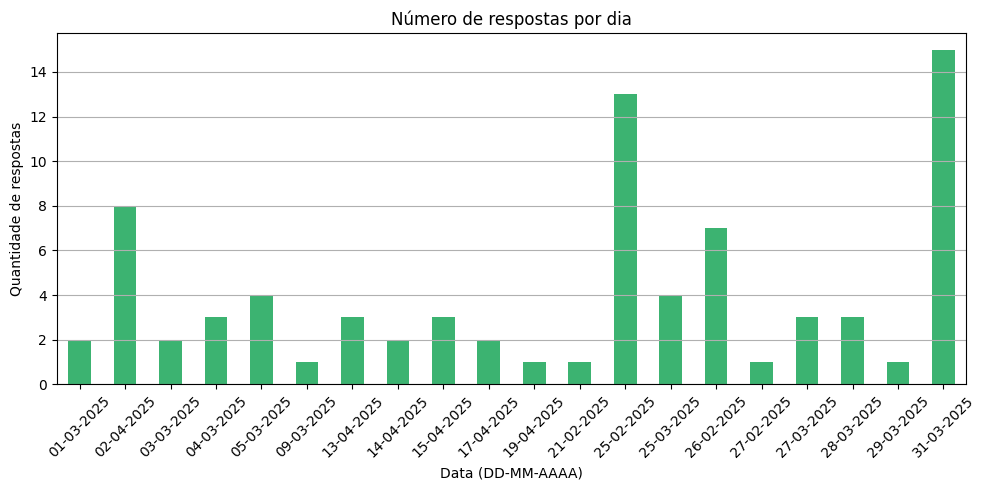

In [ ]:
# @title Número de respostas por dia

# 2. Converter para datetime diretamente
df['DataHora'] = pd.to_datetime(df['Carimbo de data/hora'])

# 3. Criar coluna com a data formatada como DIA-MÊS-ANO
df['DataFormatada'] = df['DataHora'].dt.strftime('%d-%m-%Y')

# 4. Contar respostas por dia formatado
respostas_por_dia = df['DataFormatada'].value_counts().sort_index()

# 5. Gerar gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
respostas_por_dia.plot(kind='bar', color='mediumseagreen')
plt.title('Número de respostas por dia')
plt.xlabel('Data (DD-MM-AAAA)')
plt.ylabel('Quantidade de respostas')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Número de respostas por hora do dia')

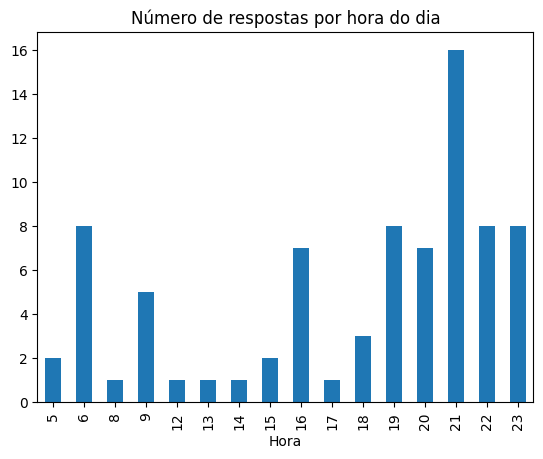

In [ ]:
# @title Respostas por horário
df['Hora'] = df['DataHora'].dt.hour
respostas_por_hora = df['Hora'].value_counts().sort_index()

respostas_por_hora.plot(kind='bar')
plt.title('Número de respostas por hora do dia')

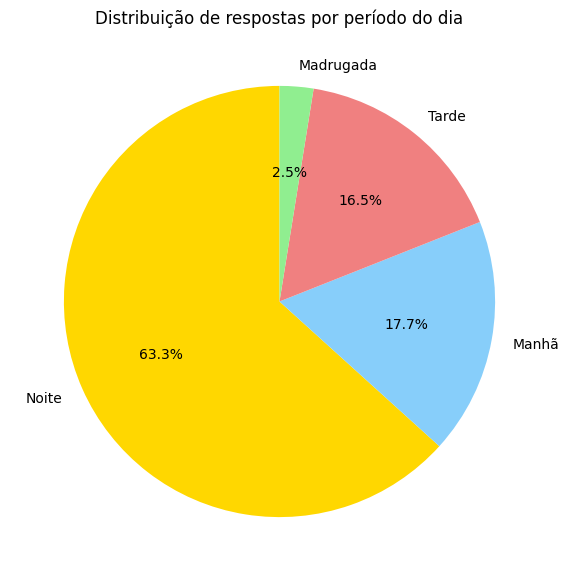

In [ ]:
# @title Distribuição de respostas por período do dia

# 2. Converter para string e remover ' GMT-3' (se existir)
df['Carimbo de data/hora'] = df['Carimbo de data/hora'].astype(str).str.replace(' GMT-3', '')

# 3. Converter para datetime, ignorando erros
df['DataHora'] = pd.to_datetime(df['Carimbo de data/hora'], errors='coerce')

# 4. Extrair a hora
df['Hora'] = df['DataHora'].dt.hour

# 5. Definir períodos do dia
def periodo_do_dia(hora):
    if pd.isna(hora):
        return 'Desconhecido'
    if 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora <= 23:
        return 'Noite'
    else:
        return 'Madrugada'

df['Periodo'] = df['Hora'].apply(periodo_do_dia)

# 6. Contar por período
contagem_periodos = df['Periodo'].value_counts()

# 7. Gráfico de pizza
plt.figure(figsize=(7,7))
contagem_periodos.plot.pie(autopct='%1.1f%%', startangle=90,
                          colors=['gold', 'lightskyblue', 'lightcoral', 'lightgreen'])
plt.title('Distribuição de respostas por período do dia')
plt.ylabel('')
plt.show()

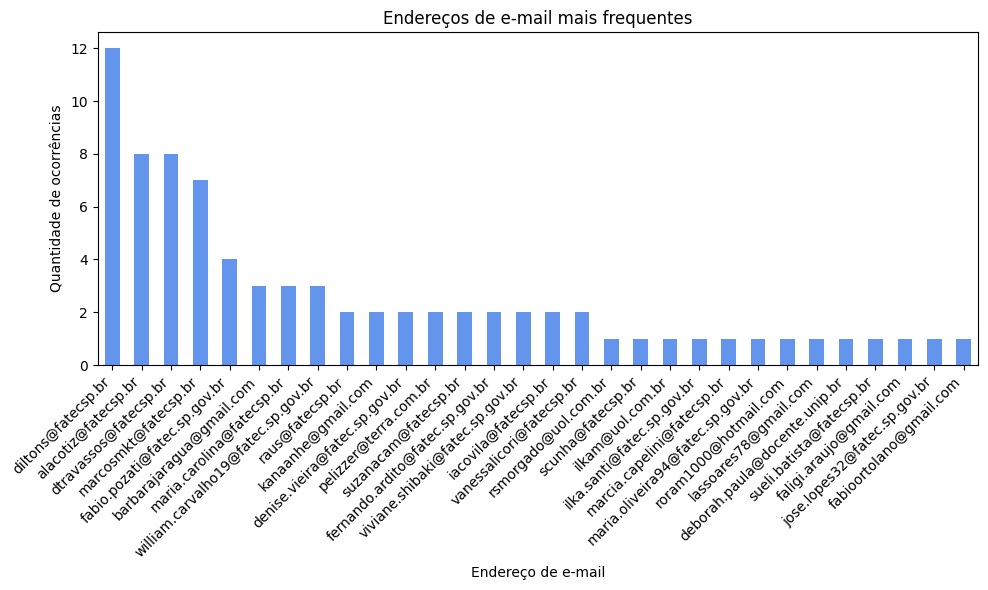

In [ ]:
# @title Endereços de e-mail mais frequentes

# Contar quantas vezes cada e-mail aparece
contagem_emails = df['Endereço de e-mail'].value_counts()

# Mostrar os 10 e-mails que mais aparecem (você pode ajustar)
top_10 = contagem_emails.head(100)

# Gráfico de barras para os 10 e-mails mais frequentes
plt.figure(figsize=(10,6))
top_10.plot(kind='bar', color='cornflowerblue')
plt.title('Endereços de e-mail mais frequentes')
plt.xlabel('Endereço de e-mail')
plt.ylabel('Quantidade de ocorrências')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

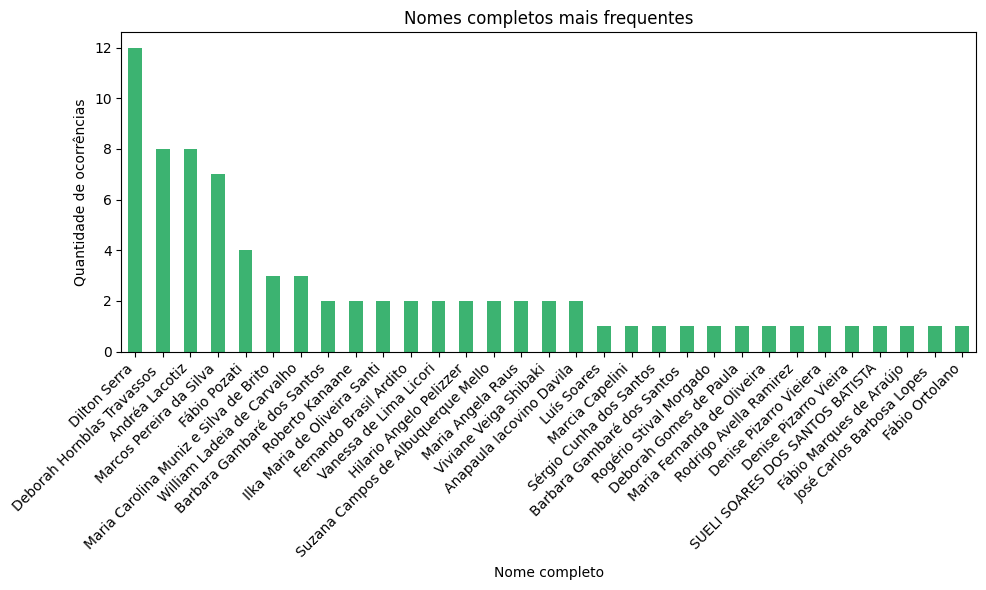

In [ ]:
# @title Nomes completos mais frequentes

# Contar quantas vezes cada nome completo aparece
contagem_nomes = df['Nome completo'].value_counts()

# Selecionar os 10 nomes mais frequentes
top_10_nomes = contagem_nomes.head(100)

# Plotar gráfico de barras
plt.figure(figsize=(10,6))
top_10_nomes.plot(kind='bar', color='mediumseagreen')
plt.title('Nomes completos mais frequentes')
plt.xlabel('Nome completo')
plt.ylabel('Quantidade de ocorrências')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

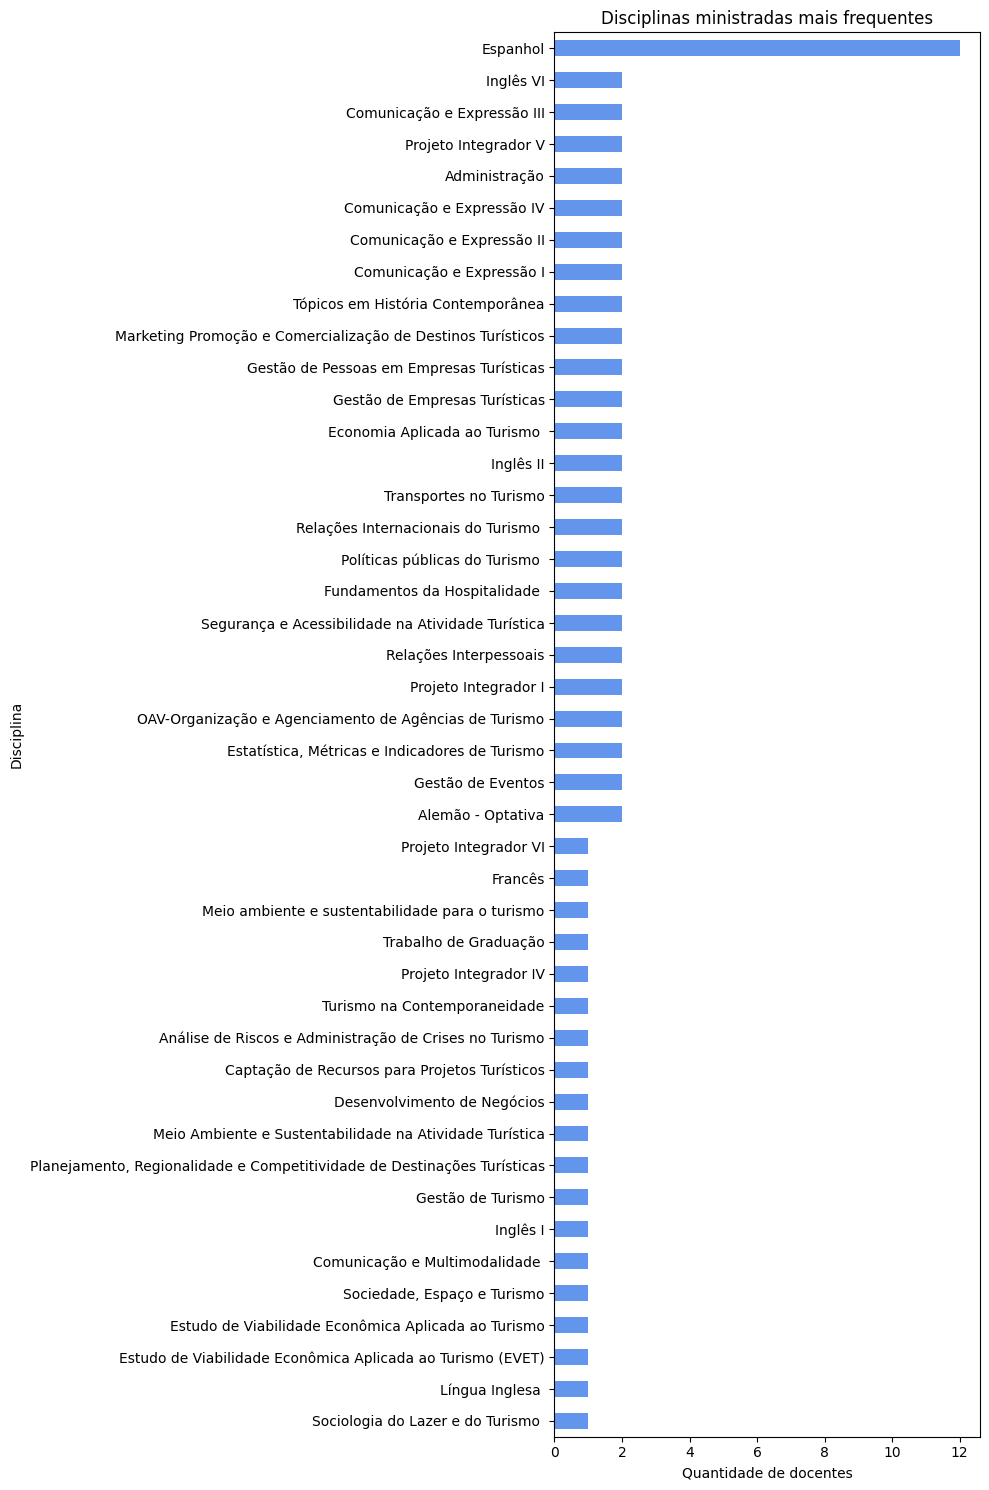

In [ ]:
# @title Disciplinas mais frequências

# Contar a frequência de cada disciplina
contagem_disciplinas = df['Disciplina ministrada (escrever o nome por extenso)'].value_counts()

# Selecionar as top 10 disciplinas
top_10_disciplinas = contagem_disciplinas.head(100)

# Plotar gráfico de barras horizontal
plt.figure(figsize=(10,15))
top_10_disciplinas.plot(kind='barh', color='cornflowerblue')
plt.title('Disciplinas ministradas mais frequentes')
plt.xlabel('Quantidade de docentes')
plt.ylabel('Disciplina')
plt.gca().invert_yaxis()  # Inverte a ordem para mostrar a maior em cima
plt.tight_layout()
plt.show()


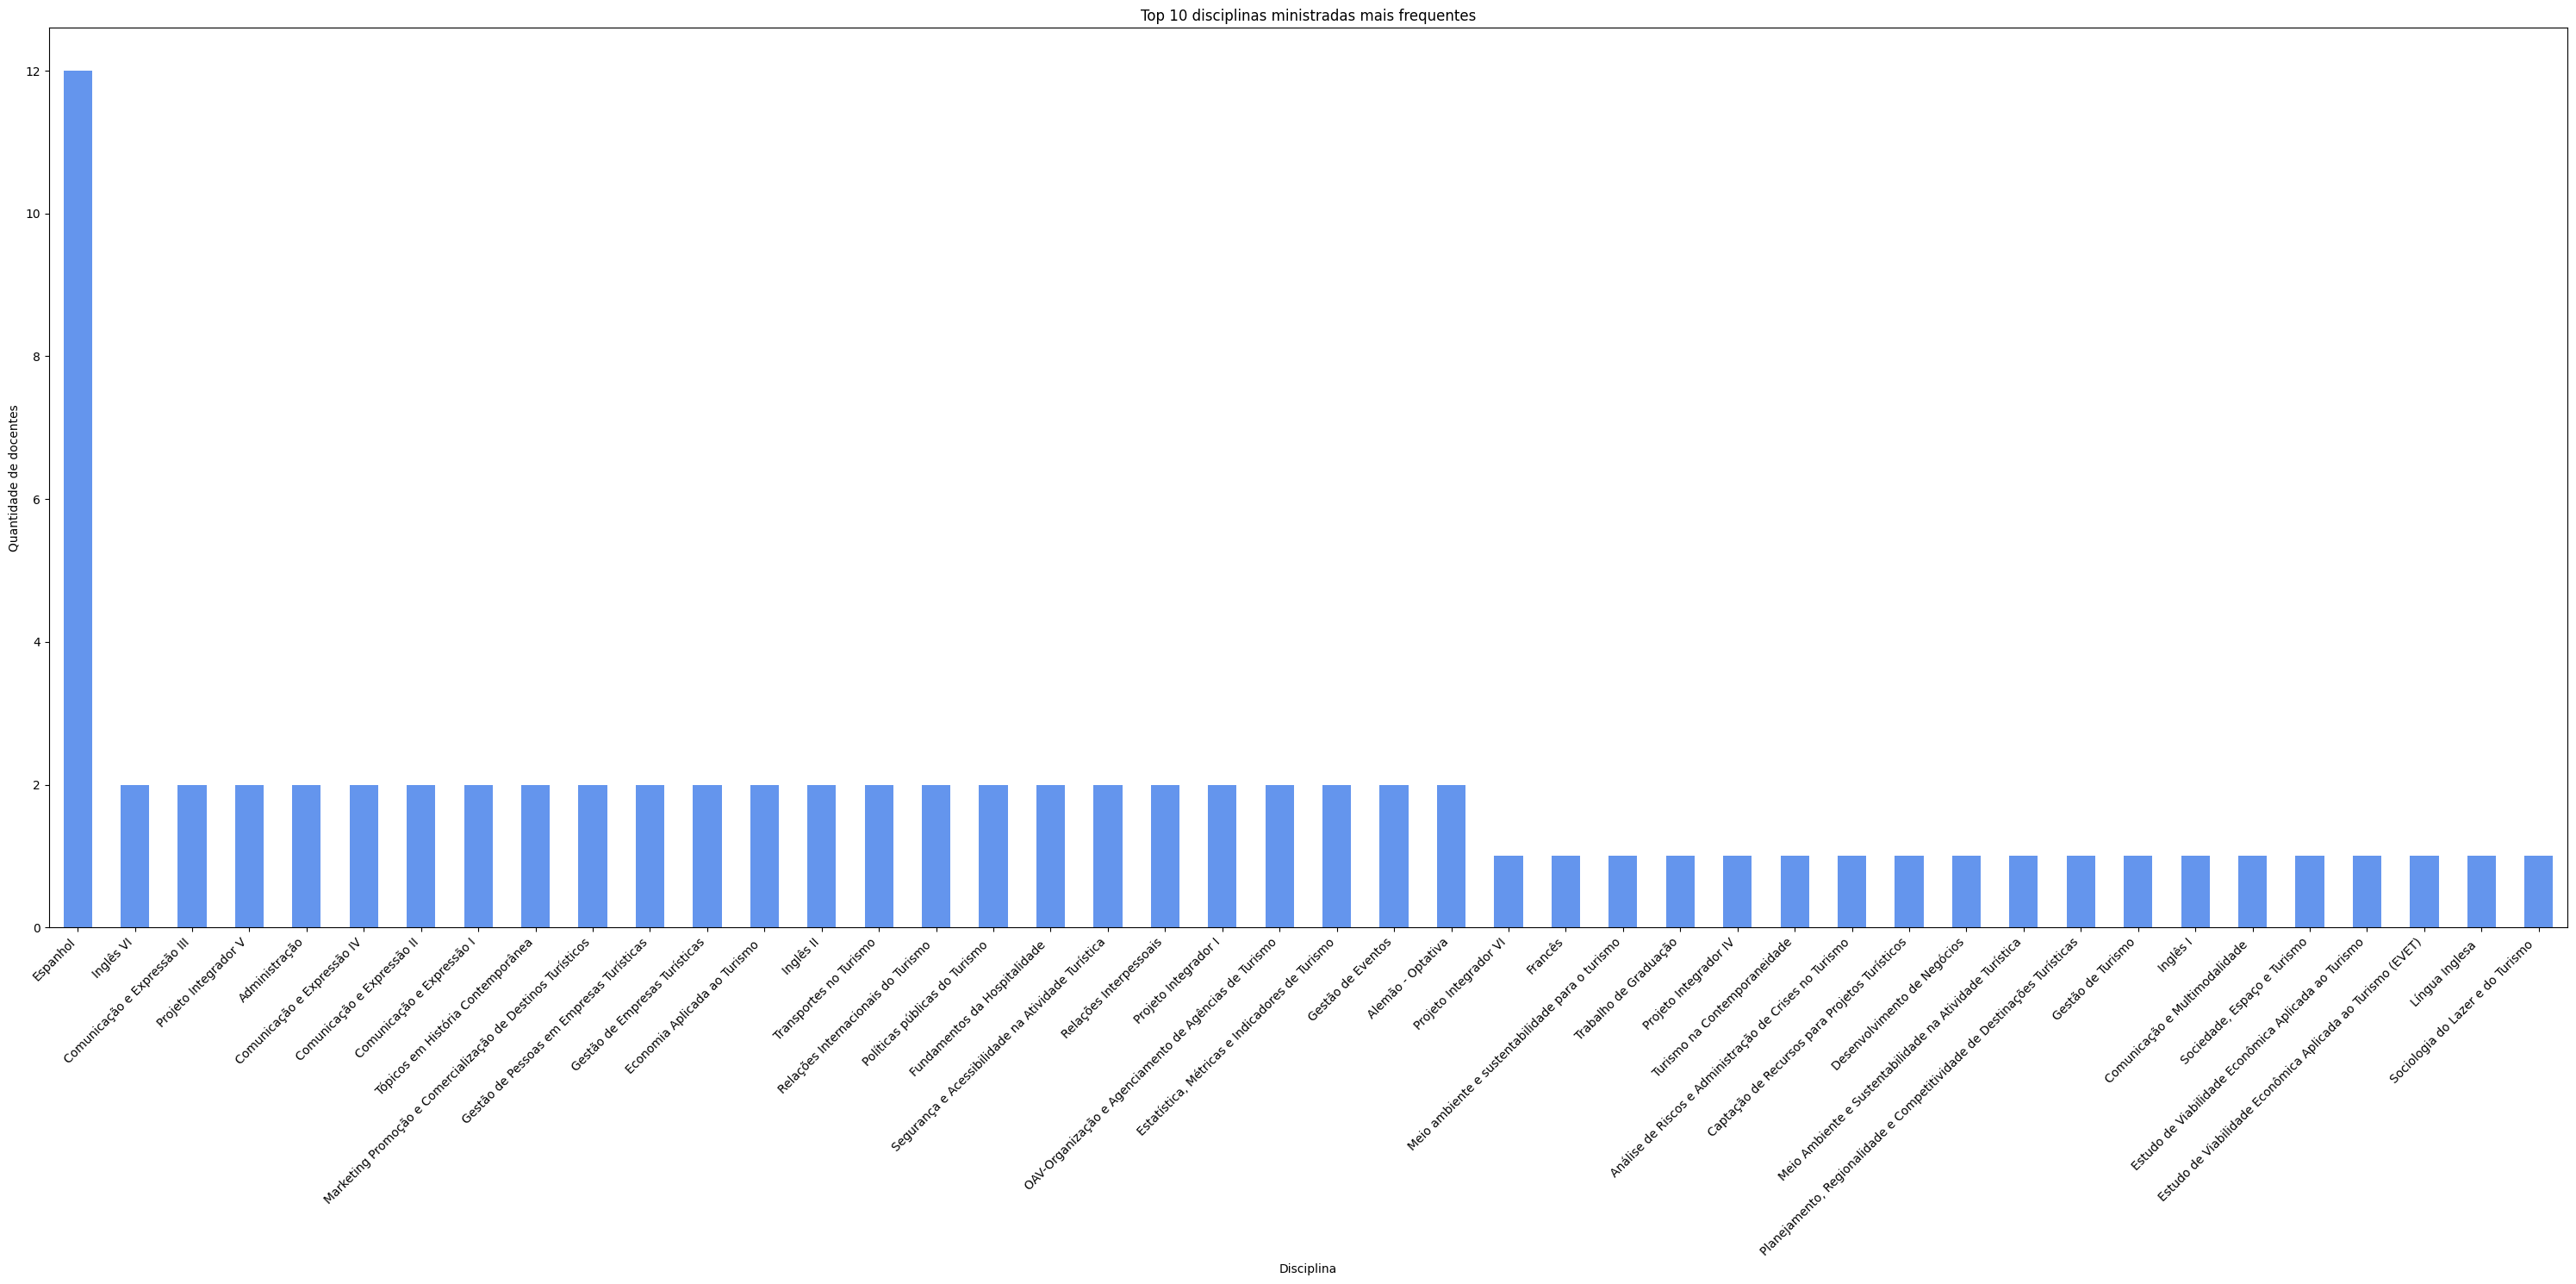

In [ ]:
# @title Disciplinas mais frequências

# Contar a frequência de cada disciplina
contagem_disciplinas = df['Disciplina ministrada (escrever o nome por extenso)'].value_counts()

# Se quiser, mostrar todas as disciplinas, ou só as top 10:
top_10_disciplinas = contagem_disciplinas.head(100)

# Plotar gráfico de barras
plt.figure(figsize=(30,15))
top_10_disciplinas.plot(kind='bar', color='cornflowerblue')
plt.title('Top 10 disciplinas ministradas mais frequentes')
plt.xlabel('Disciplina')
plt.ylabel('Quantidade de docentes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


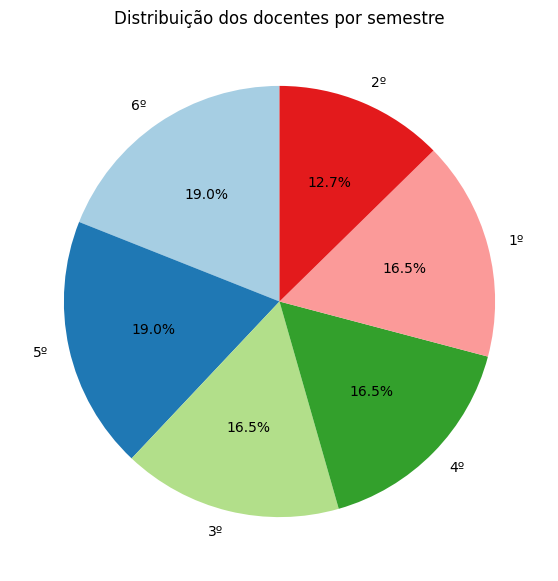

In [ ]:
# @title Distribuição dos docentes por semestre

coluna_semestre = 'Semestre '

contagem_semestres = df[coluna_semestre].value_counts()

plt.figure(figsize=(7,7))
contagem_semestres.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribuição dos docentes por semestre')
plt.ylabel('')
plt.show()


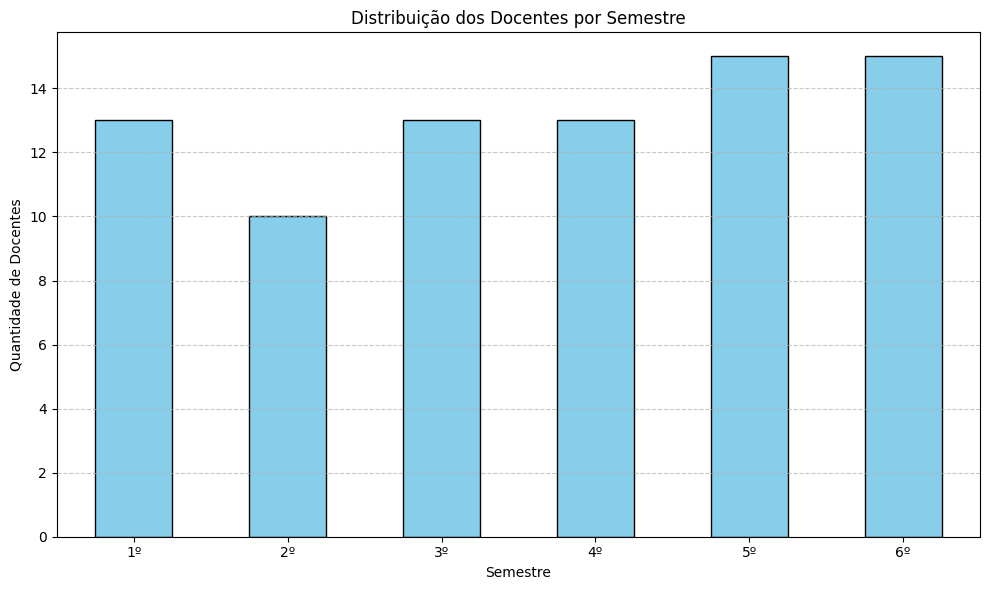

In [ ]:
# @title Distribuição dos docentes por semestre


# Nome da coluna
coluna_semestre = 'Semestre '

# Contagem de valores por semestre
contagem_semestres = df[coluna_semestre].value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(10,6))
contagem_semestres.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalização do gráfico
plt.title('Distribuição dos Docentes por Semestre')
plt.xlabel('Semestre')
plt.ylabel('Quantidade de Docentes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar

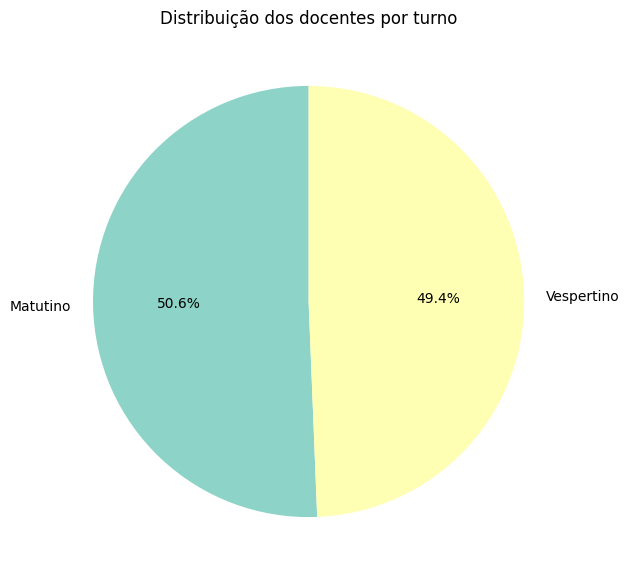

In [ ]:
# @title Distribuição dos docentes por turno

# Contar a frequência de cada turno
contagem_turnos = df['Turno'].value_counts()

# Plotar gráfico de pizza
plt.figure(figsize=(7,7))
contagem_turnos.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Distribuição dos docentes por turno')
plt.ylabel('')  # Remove o label do eixo y
plt.show()

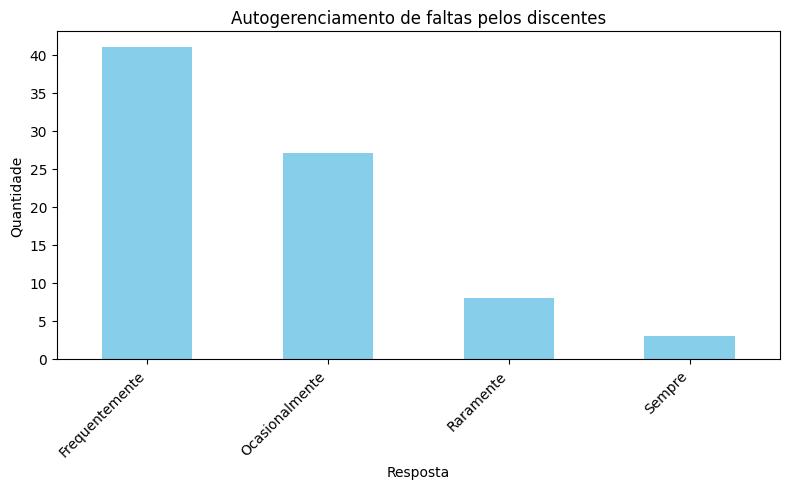

In [ ]:
# @title Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?

# Contar as respostas
contagem_respostas = df['Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?'].value_counts()

# Plotar gráfico de barras
plt.figure(figsize=(8,5))
contagem_respostas.plot(kind='bar', color='skyblue')
plt.title('Autogerenciamento de faltas pelos discentes')
plt.xlabel('Resposta')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


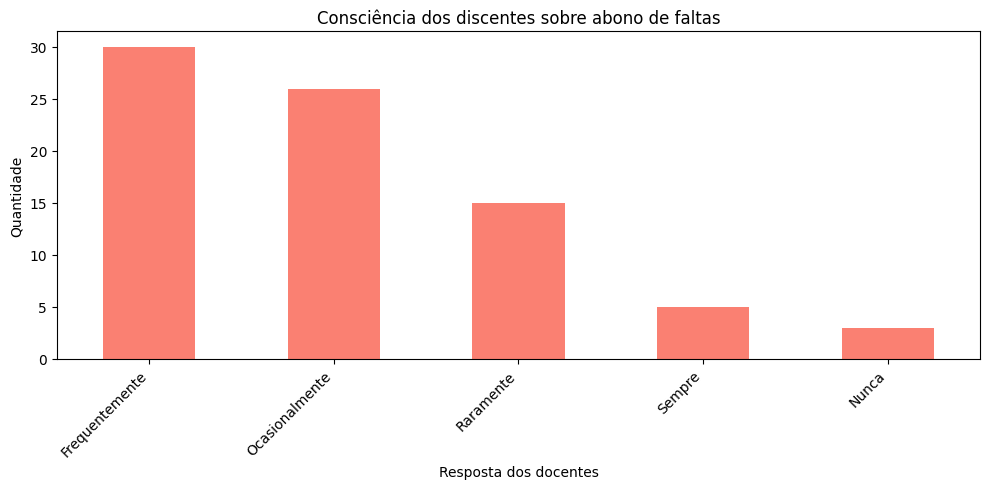

In [ ]:
# @title Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?

# Nome exato da coluna
coluna = 'Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?'

# Contar respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='salmon')
plt.title('Consciência dos discentes sobre abono de faltas')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


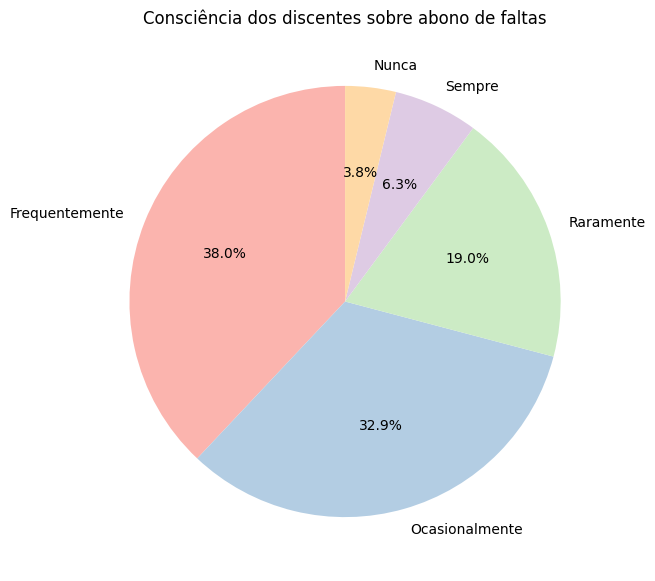

In [ ]:
# @title Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?


plt.figure(figsize=(7,7))
contagem_respostas.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Consciência dos discentes sobre abono de faltas')
plt.ylabel('')
plt.show()


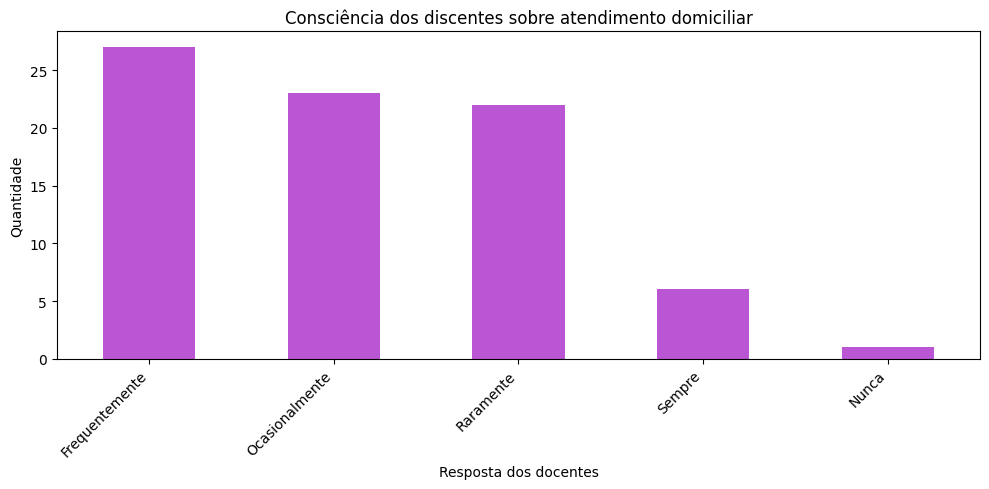

In [ ]:
# @title Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar?

# Nome exato da coluna
coluna = 'Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gerar gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumorchid')
plt.title('Consciência dos discentes sobre atendimento domiciliar')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

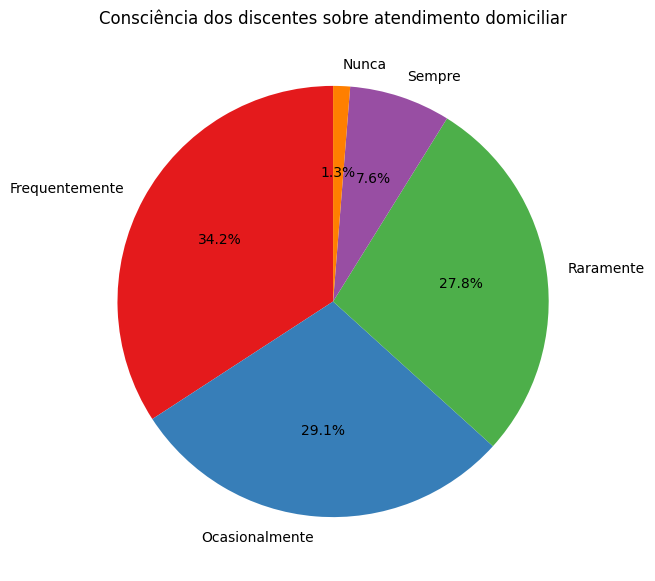

In [ ]:
# @title Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar?


plt.figure(figsize=(7,7))
contagem_respostas.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Set1.colors)
plt.title('Consciência dos discentes sobre atendimento domiciliar')
plt.ylabel('')
plt.show()


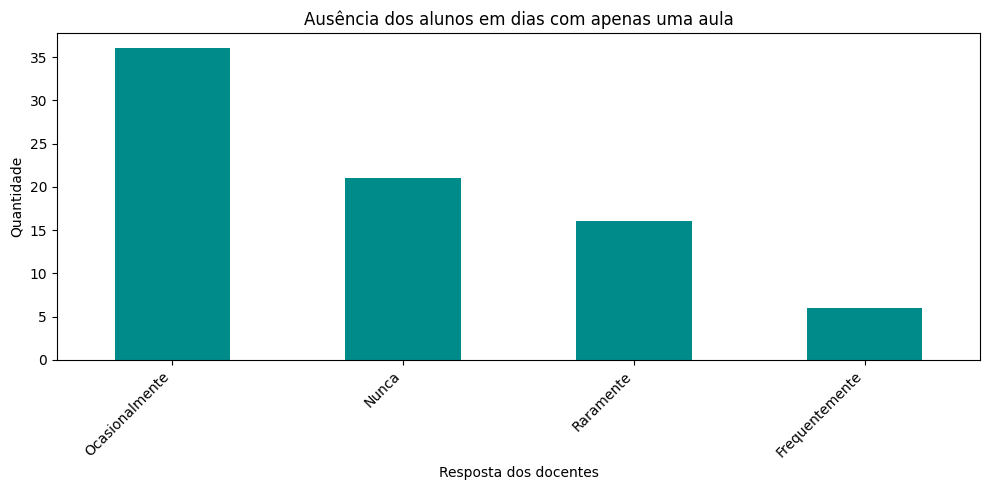

In [ ]:
# @title Na situação em que houve apenas aula de sua disciplina em uma determinada data, já ocorreu de os alunos se ausentarem de sua aula porque não haveria aula de outro professor?

# Nome exato da coluna
coluna = 'Na situação em que houve apenas aula de sua disciplina em uma determinada data, já ocorreu de os alunos se ausentarem de sua aula porque não haveria aula de outro professor?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='darkcyan')
plt.title('Ausência dos alunos em dias com apenas uma aula')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

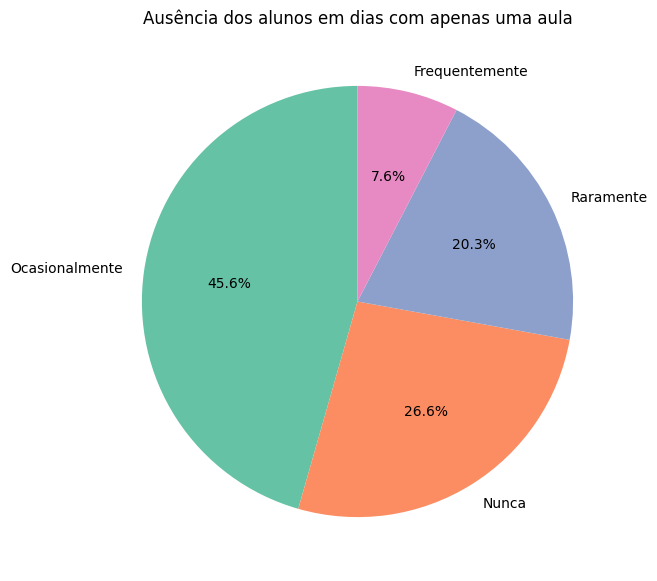

In [ ]:
# @title Na situação em que houve apenas aula de sua disciplina em uma determinada data, já ocorreu de os alunos se ausentarem de sua aula porque não haveria aula de outro professor?


plt.figure(figsize=(7,7))
contagem_respostas.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Set2.colors)
plt.title('Ausência dos alunos em dias com apenas uma aula')
plt.ylabel('')
plt.show()

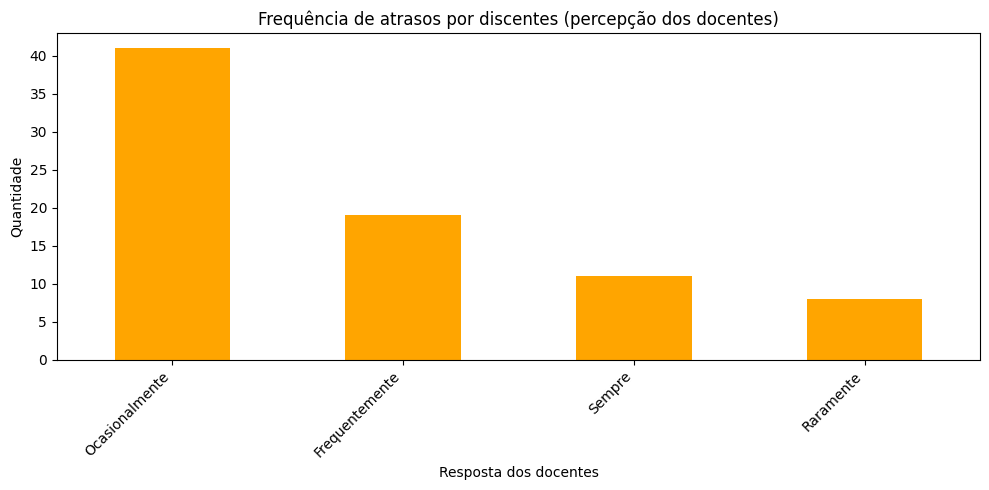

In [ ]:
# @title Existem discentes que costumam entrar ou querer entrar atrasados nas aulas?

# Nome exato da coluna
coluna = 'Existem discentes que costumam entrar ou querer entrar atrasados nas aulas?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gerar gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='orange')
plt.title('Frequência de atrasos por discentes (percepção dos docentes)')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

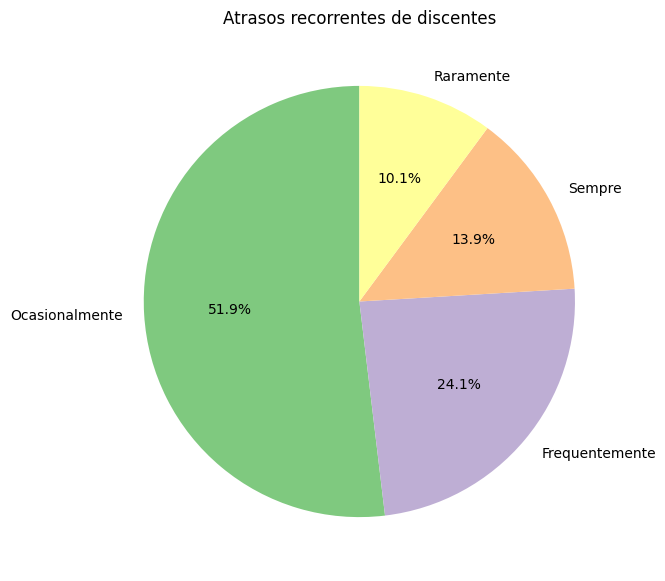

In [ ]:
# @title Existem discentes que costumam entrar ou querer entrar atrasados nas aulas?


plt.figure(figsize=(7,7))
contagem_respostas.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Accent.colors)
plt.title('Atrasos recorrentes de discentes')
plt.ylabel('')
plt.show()


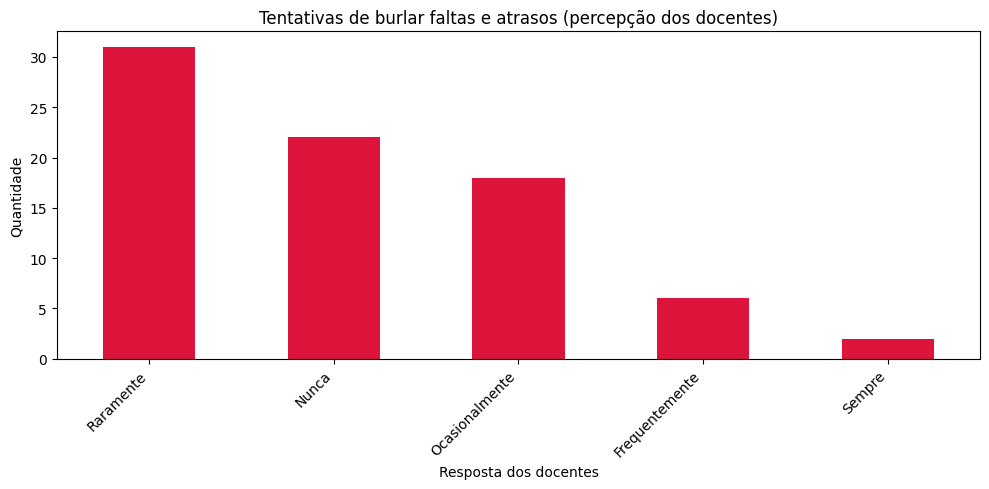

In [ ]:
# @title Você já enfrentou situações em que os alunos tentam burlar faltas e atrasos, ignorando completamente as normas?

# Nome exato da coluna
coluna = 'Você já enfrentou situações em que os alunos tentam burlar faltas e atrasos, ignorando completamente as normas?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gerar gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='crimson')
plt.title('Tentativas de burlar faltas e atrasos (percepção dos docentes)')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

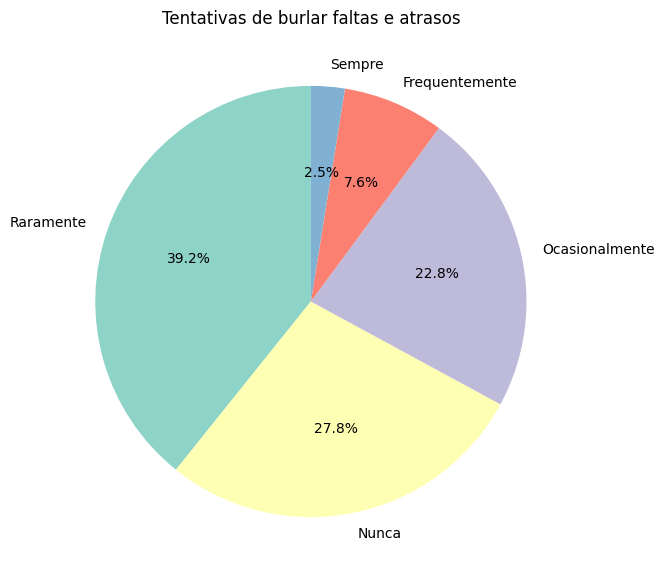

In [ ]:
# @title Você já enfrentou situações em que os alunos tentam burlar faltas e atrasos, ignorando completamente as normas?


plt.figure(figsize=(7,7))
contagem_respostas.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Tentativas de burlar faltas e atrasos')
plt.ylabel('')
plt.show()


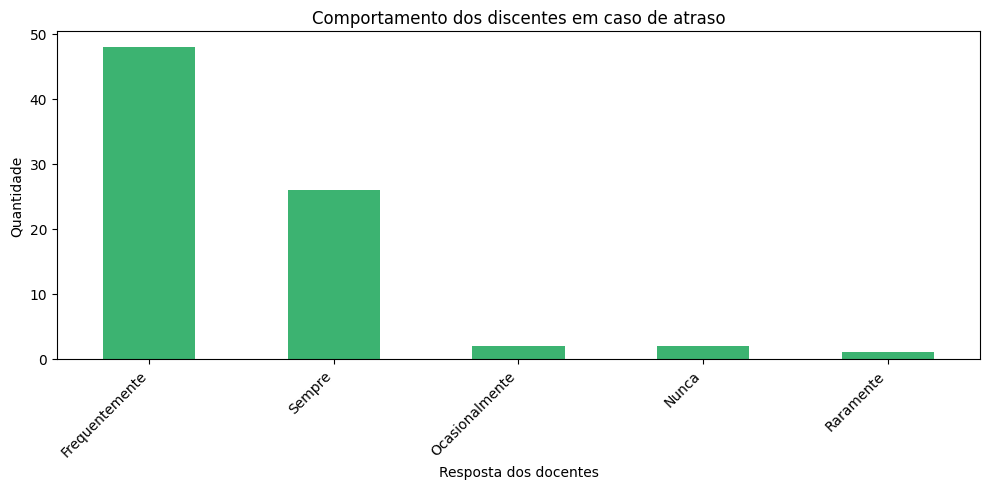

In [ ]:
# @title Em caso de atraso, comportam-se de maneira respeitosa?

# Nome exato da coluna
coluna = 'Em caso de atraso, comportam-se de maneira respeitosa?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumseagreen')
plt.title('Comportamento dos discentes em caso de atraso')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

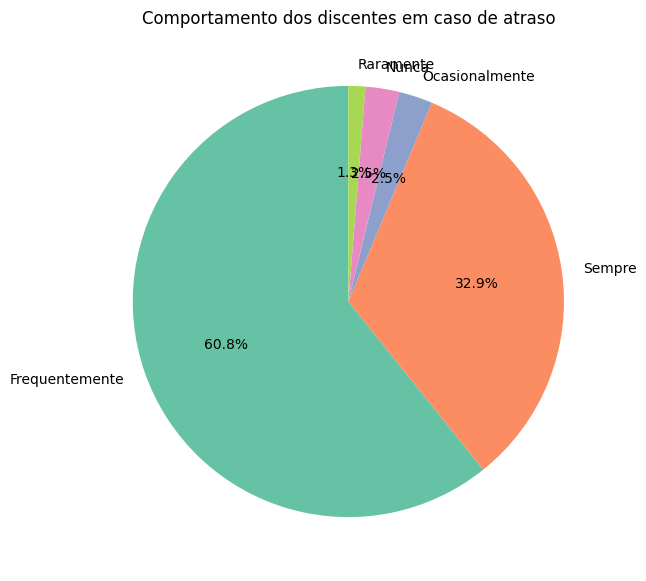

In [ ]:
# @title Em caso de atraso, comportam-se de maneira respeitosa?

plt.figure(figsize=(7,7))
contagem_respostas.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Set2.colors)
plt.title('Comportamento dos discentes em caso de atraso')
plt.ylabel('')
plt.show()


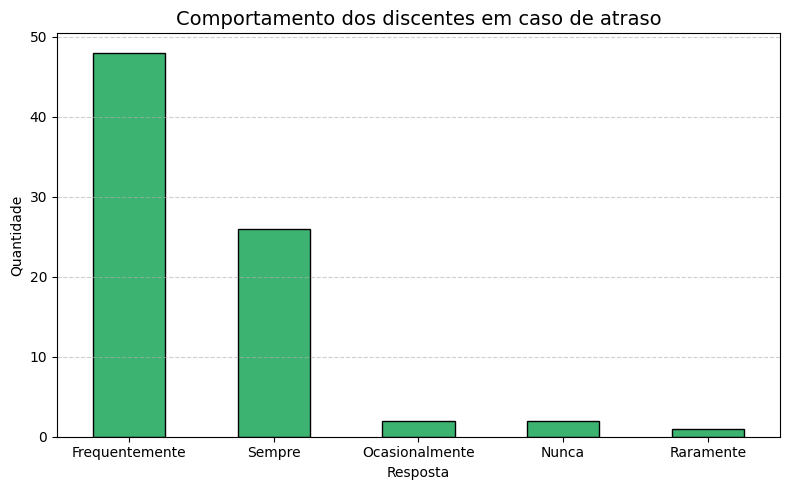

In [ ]:
# @title Em caso de atraso, comportam-se de maneira respeitosa?

plt.figure(figsize=(8,5))
contagem_respostas.plot(kind='bar', color='mediumseagreen', edgecolor='black')

plt.title('Comportamento dos discentes em caso de atraso', fontsize=14)
plt.xlabel('Resposta')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


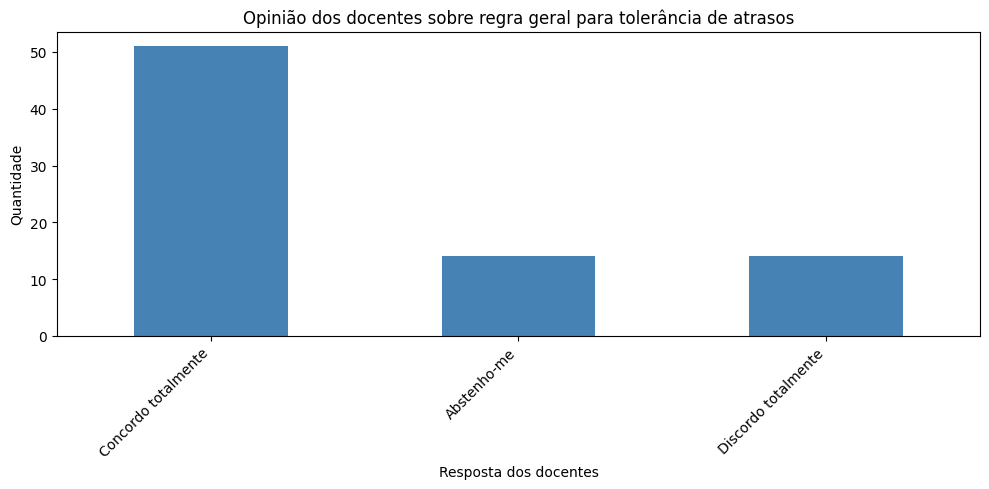

In [ ]:
# @title Ainda sobre ausências e pontualidade, embora o professor tenha plena autonomia em sala de aula, você consideraria positivo haver uma regra geral, instituída no curso, para tolerância de atrasos?

# Nome exato da coluna
coluna = 'Ainda sobre ausências e pontualidade, embora o professor tenha plena autonomia em sala de aula, você consideraria positivo haver uma regra geral, instituída no curso, para tolerância de atrasos?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='steelblue')
plt.title('Opinião dos docentes sobre regra geral para tolerância de atrasos')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

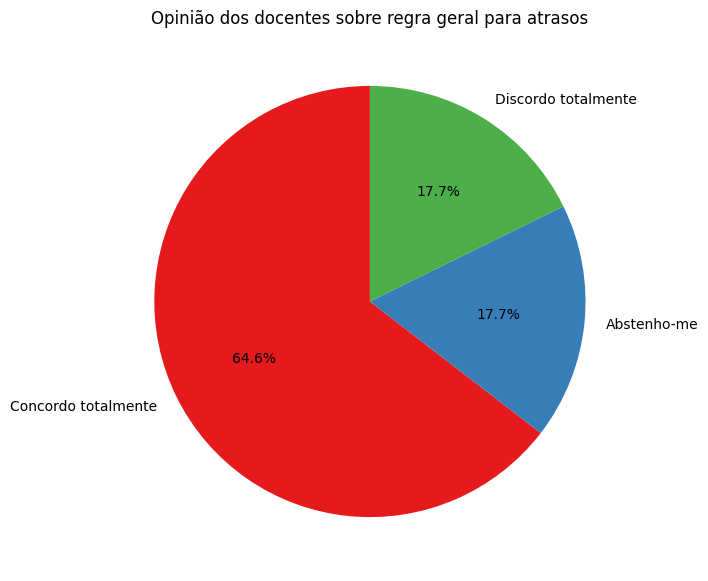

In [ ]:
# @title Ainda sobre ausências e pontualidade, embora o professor tenha plena autonomia em sala de aula, você consideraria positivo haver uma regra geral, instituída no curso, para tolerância de atrasos?


plt.figure(figsize=(7,7))
contagem_respostas.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Set1.colors)
plt.title('Opinião dos docentes sobre regra geral para atrasos')
plt.ylabel('')
plt.show()


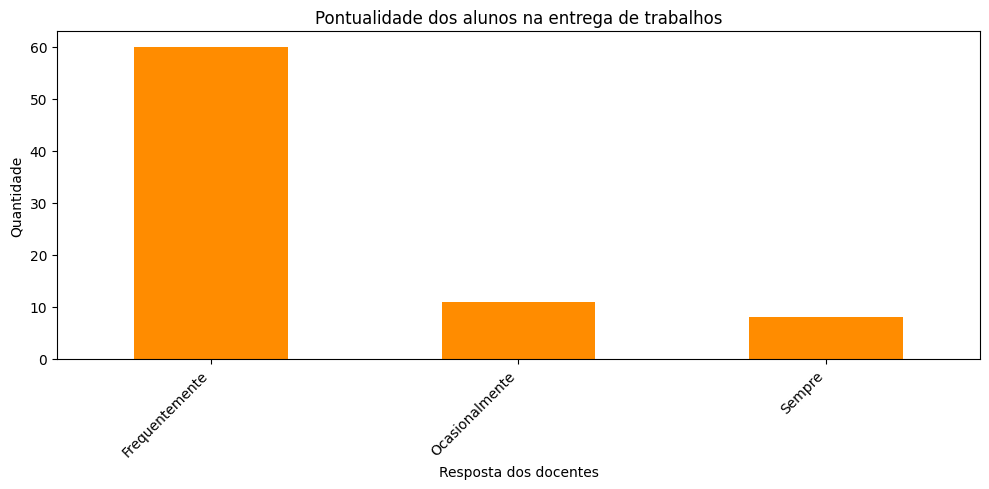

In [ ]:
# @title Em geral, os alunos entregam projetos e trabalhos dentro do prazo?

# Nome exato da coluna
coluna = 'Em geral, os alunos entregam projetos e trabalhos dentro do prazo?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='darkorange')
plt.title('Pontualidade dos alunos na entrega de trabalhos')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

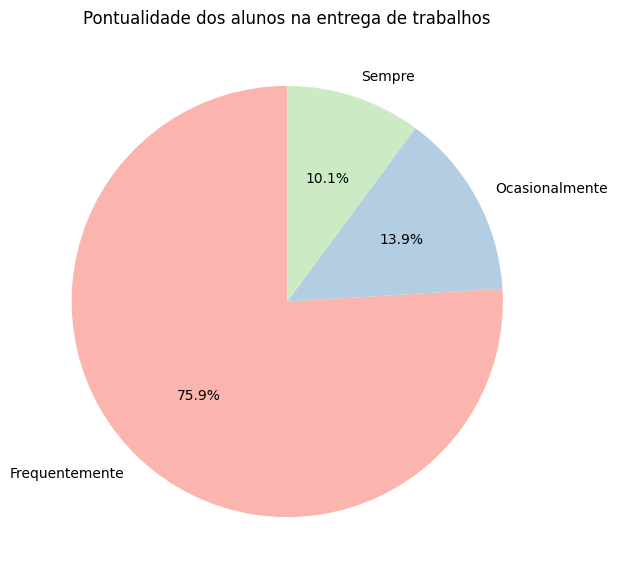

In [ ]:
# @title Em geral, os alunos entregam projetos e trabalhos dentro do prazo?


plt.figure(figsize=(7,7))
contagem_respostas.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Pontualidade dos alunos na entrega de trabalhos')
plt.ylabel('')
plt.show()


In [ ]:
# @title Quanto a atitudes DESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano:


# 2. Remove espaços extras dos nomes das colunas
df.columns = df.columns.str.strip()

# 3. Nome exato da coluna
coluna_respostas = "Quanto a atitudes DESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano:"

# 4. Lista de todas as opções (copiada exatamente como aparecem)
opcoes = [
    "Colaboram mutuamente na realização de trabalhos em grupo, sem criar conflitos desnecessários.",
    "Compartilham entre si materiais de aula.",
    "Agem de maneira a não buscar destaque individual, respeitando as opiniões divergentes e buscando contribuir para o debate em aula.",
    "Não existem alunos que monopolizam as discussões, de modo a criar sobre si uma imagem de superioridade.",
    "Participam ativamente das discussões.",
    "Acolhem com simpatia alunos de outros semestres.",
    "Compartilham entre si informações relevantes.",
    "Participam de atividades de convivência acadêmica, como eventos, palestras e seminários.",
    "Na maioria das vezes, não é necessário chamar a atenção da turma, pedindo silêncio."
]

# 5. Inicializa o dicionário de contagem
contagem = {opcao: 0 for opcao in opcoes}

# 6. Conta quantas vezes cada opção aparece
for resposta in df[coluna_respostas]:
    if isinstance(resposta, str):  # verifica se é string válida
        for opcao in opcoes:
            if opcao in resposta:
                contagem[opcao] += 1

# 7. Cria um DataFrame com os resultados
resultado = pd.DataFrame(list(contagem.items()), columns=['Opção', 'Frequência'])
resultado = resultado.sort_values(by='Frequência', ascending=False)

# 8. Exibe os dados
print(resultado)

                                               Opção  Frequência
1           Compartilham entre si materiais de aula.          69
0  Colaboram mutuamente na realização de trabalho...          62
6      Compartilham entre si informações relevantes.          56
8  Na maioria das vezes, não é necessário chamar ...          46
5   Acolhem com simpatia alunos de outros semestres.          45
7  Participam de atividades de convivência acadêm...          44
2  Agem de maneira a não buscar destaque individu...          36
4              Participam ativamente das discussões.          32
3  Não existem alunos que monopolizam as discussõ...          31


/tmp/ipython-input-461-393101318.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


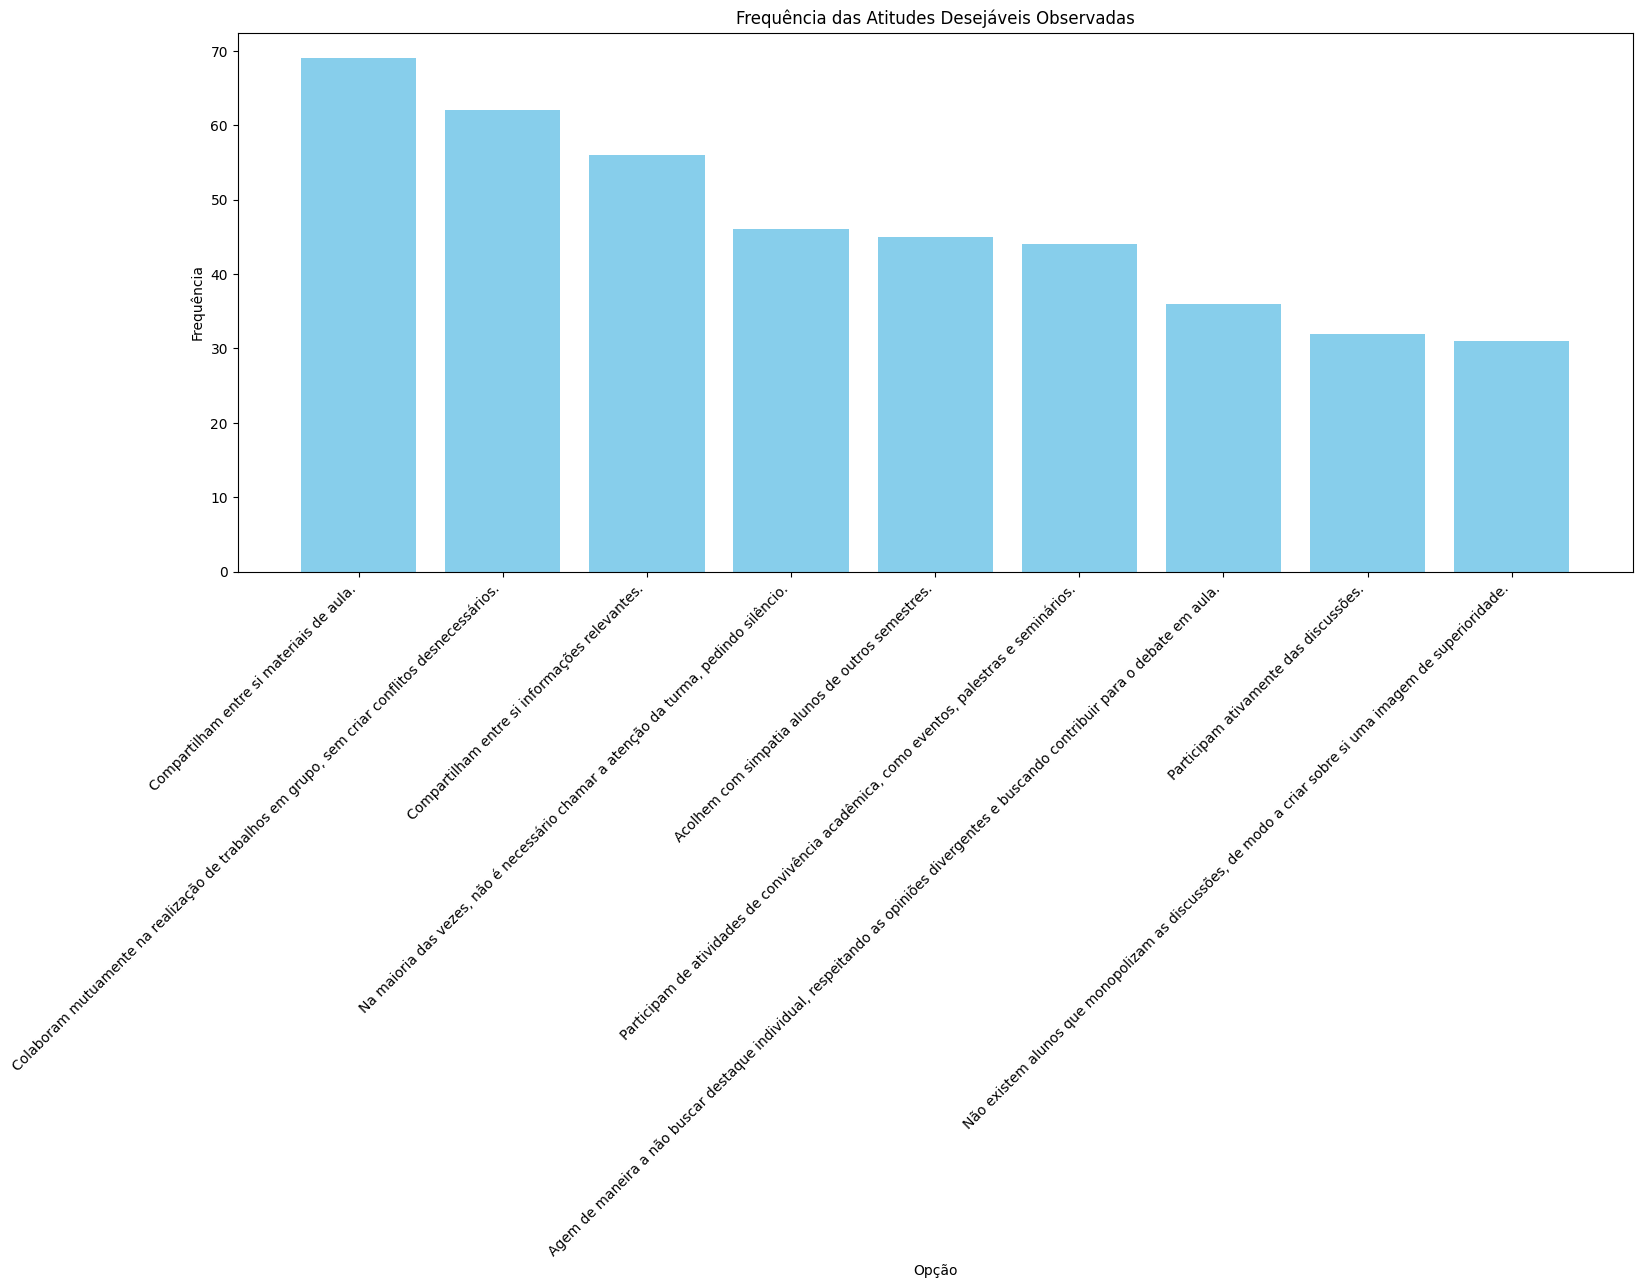

In [ ]:
# @title Quanto a atitudes DESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano:

# 2. Remove espaços extras dos nomes das colunas
df.columns = df.columns.str.strip()

# 3. Nome da coluna
coluna_respostas = "Quanto a atitudes DESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano:"

# 4. Lista das opções possíveis
opcoes = [
    "Colaboram mutuamente na realização de trabalhos em grupo, sem criar conflitos desnecessários.",
    "Compartilham entre si materiais de aula.",
    "Agem de maneira a não buscar destaque individual, respeitando as opiniões divergentes e buscando contribuir para o debate em aula.",
    "Não existem alunos que monopolizam as discussões, de modo a criar sobre si uma imagem de superioridade.",
    "Participam ativamente das discussões.",
    "Acolhem com simpatia alunos de outros semestres.",
    "Compartilham entre si informações relevantes.",
    "Participam de atividades de convivência acadêmica, como eventos, palestras e seminários.",
    "Na maioria das vezes, não é necessário chamar a atenção da turma, pedindo silêncio."
]

# 5. Contagem de cada opção
contagem = {opcao: 0 for opcao in opcoes}
for resposta in df[coluna_respostas]:
    if isinstance(resposta, str):
        for opcao in opcoes:
            if opcao in resposta:
                contagem[opcao] += 1

# 6. Criar DataFrame com resultados (ordem decrescente para melhor visualização)
resultado = pd.DataFrame(list(contagem.items()), columns=['Opção', 'Frequência'])
resultado = resultado.sort_values(by='Frequência', ascending=False)

# 7. Plotar gráfico de barras verticais
plt.figure(figsize=(18, 7))
plt.bar(resultado['Opção'], resultado['Frequência'], color='skyblue')
plt.ylabel('Frequência')
plt.xlabel('Opção')
plt.title('Frequência das Atitudes Desejáveis Observadas')
plt.xticks(rotation=45, ha='right')  # gira os nomes para não sobrepor
plt.tight_layout()
plt.show()

In [ ]:
# @title Quanto a atitudes INDESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano


# Nome exato da coluna
coluna_indesejaveis = "Quanto a atitudes INDESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano:"

# Lista fixa das frases indesejáveis
frases_indesejaveis = [
    'Recorrem a pedidos de meios de avaliação paralela, ou seja, ou não previstos no início do semestre ou não aplicáveis a todos.',
    'Ausentam-se da aula para fazer atividades de outras disciplinas.',
    'Buscam ser dispensados da aula para fazer atividades de outras disciplinas.',
    'Existem recusas em participar de atividades coletivas.',
    'Buscam atendimento individualizado, procurando inteirar-se de discussões, atividades avaliativas e conteúdos de aula pretéritos.',
    'Buscam atendimento individualizado, tentando sanar dúvidas sobre o conteúdo no início ou no final das aulas.',
    'Buscam atendimento individualizado, procurando resolver problemas relativos a sua situação de matrícula e afins.',
    'Recorrem ao professor para solução de conflitos ocorridos durante a realização de atividades em grupo.',
    'Na maior parte das vezes, é necessário pedir silêncio para continuar o debate.',
    'Interrompem a aula para fazer perguntas alheias ao assunto em pauta.',
    'Conduzem as discussões para assuntos alheios ao tema tratado.'
]

# Remove respostas nulas
respostas_indesejaveis = df[coluna_indesejaveis].dropna()

# Inicializa o dicionário de contagem
contagem_indesejaveis = {frase: 0 for frase in frases_indesejaveis}

# Conta quantas vezes cada frase aparece
for resposta in respostas_indesejaveis:
    for frase in frases_indesejaveis:
        if frase in resposta:
            contagem_indesejaveis[frase] += 1

# Cria DataFrame a partir do dicionário e ordena decrescente
resultado_indesejaveis = pd.DataFrame(
    list(contagem_indesejaveis.items()), columns=['Atitude Indesejável', 'Frequência']
).sort_values(by='Frequência', ascending=False)

# Exibe o DataFrame
print(resultado_indesejaveis)


                                  Atitude Indesejável  Frequência
1   Ausentam-se da aula para fazer atividades de o...          28
0   Recorrem a pedidos de meios de avaliação paral...          24
5   Buscam atendimento individualizado, tentando s...          24
2   Buscam ser dispensados da aula para fazer ativ...          20
4   Buscam atendimento individualizado, procurando...          20
7   Recorrem ao professor para solução de conflito...          14
6   Buscam atendimento individualizado, procurando...          13
3   Existem recusas em participar de atividades co...           8
9   Interrompem a aula para fazer perguntas alheia...           8
8   Na maior parte das vezes, é necessário pedir s...           6
10  Conduzem as discussões para assuntos alheios a...           6


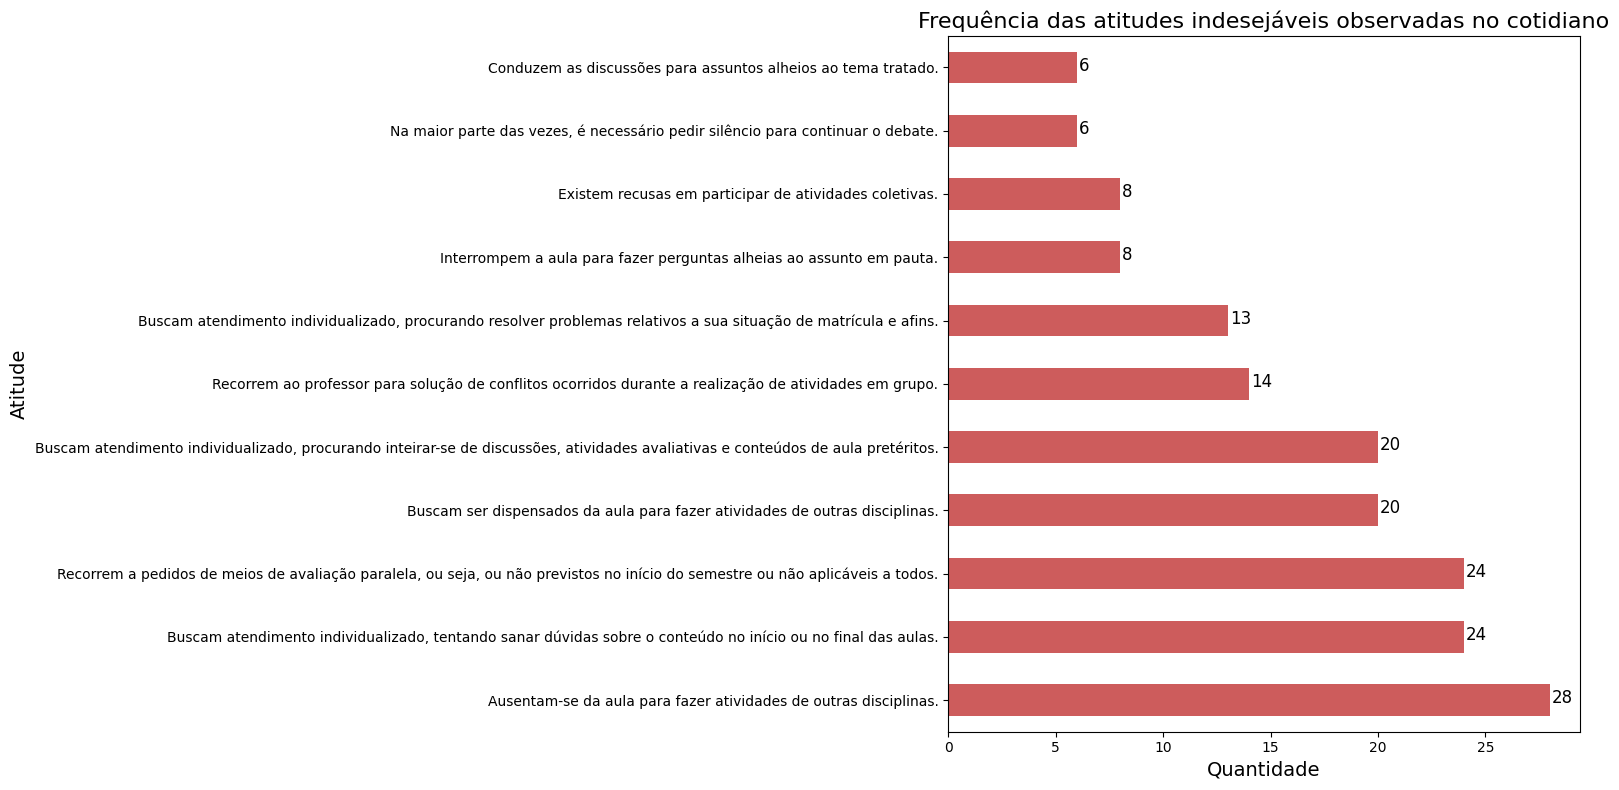

In [ ]:
# @title Quanto a atitudes INDESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano

# Nome exato da coluna (ajuste se necessário)
coluna = 'Quanto a atitudes INDESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano:'

# Lista fixa de frases indesejáveis
frases_indesejaveis = [
    'Recorrem a pedidos de meios de avaliação paralela, ou seja, ou não previstos no início do semestre ou não aplicáveis a todos.',
    'Ausentam-se da aula para fazer atividades de outras disciplinas.',
    'Buscam ser dispensados da aula para fazer atividades de outras disciplinas.',
    'Existem recusas em participar de atividades coletivas.',
    'Buscam atendimento individualizado, procurando inteirar-se de discussões, atividades avaliativas e conteúdos de aula pretéritos.',
    'Buscam atendimento individualizado, tentando sanar dúvidas sobre o conteúdo no início ou no final das aulas.',
    'Buscam atendimento individualizado, procurando resolver problemas relativos a sua situação de matrícula e afins.',
    'Recorrem ao professor para solução de conflitos ocorridos durante a realização de atividades em grupo.',
    'Na maior parte das vezes, é necessário pedir silêncio para continuar o debate.',
    'Interrompem a aula para fazer perguntas alheias ao assunto em pauta.',
    'Conduzem as discussões para assuntos alheios ao tema tratado.'
]

# 1. Remover NaN
respostas = df[coluna].dropna()

# 2. Inicializar contagem
contagem = {frase: 0 for frase in frases_indesejaveis}

# 3. Contar frases nas respostas
for resposta in respostas:
    for frase in frases_indesejaveis:
        if frase in resposta:
            contagem[frase] += 1

# 4. Converter para Series e ordenar
contagem_series = pd.Series(contagem).sort_values(ascending=True)

# 5. Gráfico horizontal
plt.figure(figsize=(16, 8))
ax = contagem_series.plot(kind='barh', color='indianred')
plt.title('Frequência das atitudes indesejáveis observadas no cotidiano', fontsize=16)
plt.xlabel('Quantidade', fontsize=14)
plt.ylabel('Atitude', fontsize=14)
plt.gca().invert_yaxis()

# 6. Adicionar valores ao lado das barras
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.3, str(int(i.get_width())), fontsize=12)

plt.tight_layout()
plt.show()

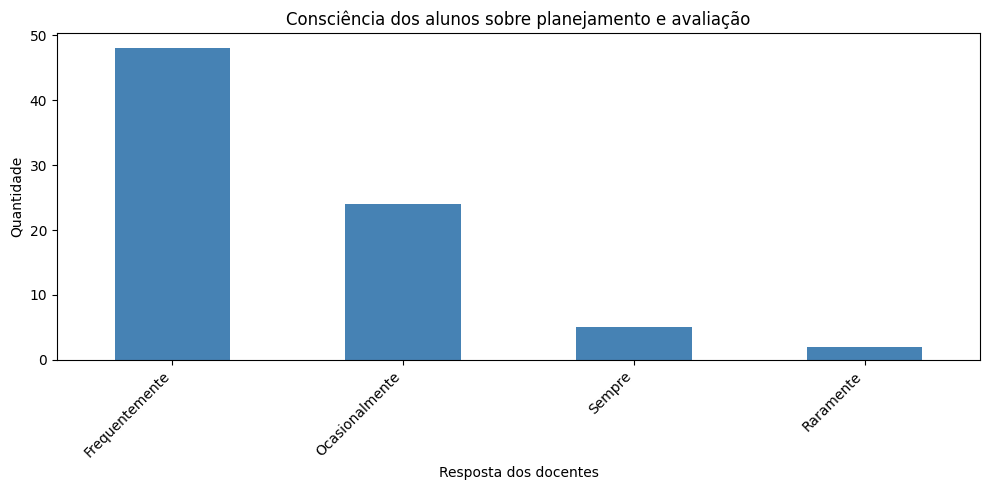

In [ ]:
# @title Os alunos mostram-se cientes dos objetivos, do planejamento das aulas e dos métodos de avaliação informados no início do semestre letivo?

coluna = 'Os alunos mostram-se cientes dos objetivos, do planejamento das aulas e dos métodos de avaliação informados no início do semestre letivo?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='steelblue')
plt.title('Consciência dos alunos sobre planejamento e avaliação')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

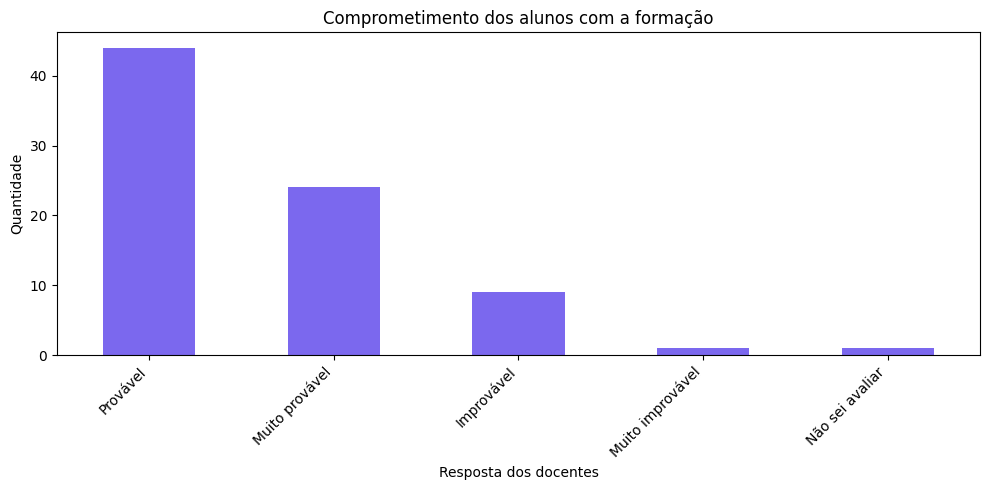

In [ ]:
# @title Acredita haver por parte dos alunos um comprometimento com a própria formação e não apenas com a aprovação na disciplina?

coluna = 'Acredita haver por parte dos alunos um comprometimento com a própria formação e não apenas com a aprovação na disciplina?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumslateblue')
plt.title('Comprometimento dos alunos com a formação')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

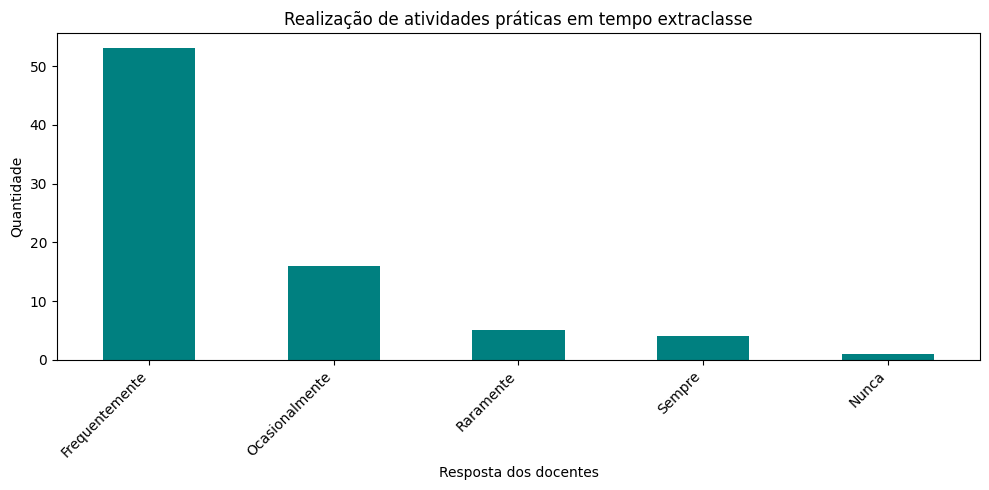

In [ ]:
# @title Caso seja solicitado, os alunos fazem as atividades práticas propostas em tempo extraclasse?

# Nome exato da coluna (com possível '\n' no final)
coluna = 'Caso seja solicitado, os alunos fazem as atividades práticas propostas em tempo extraclasse?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='teal')
plt.title('Realização de atividades práticas em tempo extraclasse')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

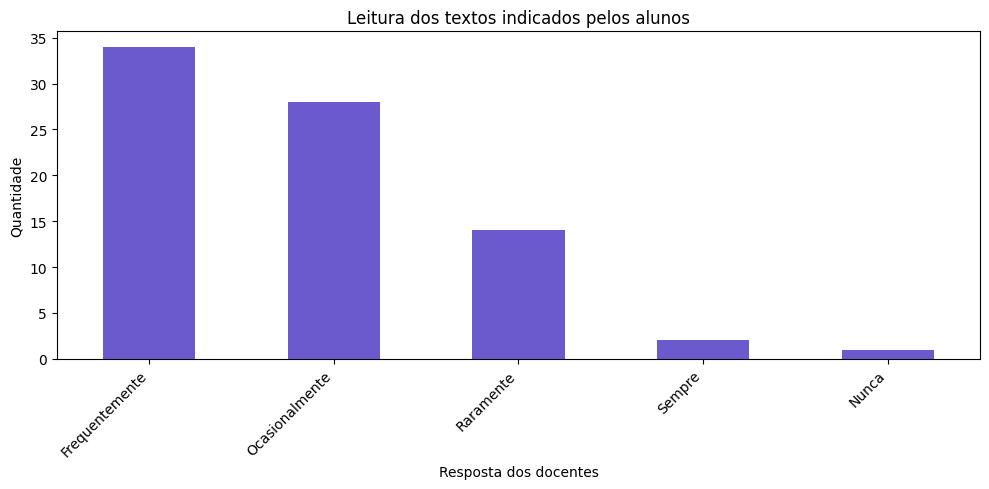

In [ ]:
# @title Os alunos leem os textos acadêmicos e/ou didáticos indicados na disciplina?

# Nome exato da coluna (com '\n' no final)
coluna = 'Os alunos leem os textos acadêmicos e/ou didáticos indicados na disciplina?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='slateblue')
plt.title('Leitura dos textos indicados pelos alunos')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

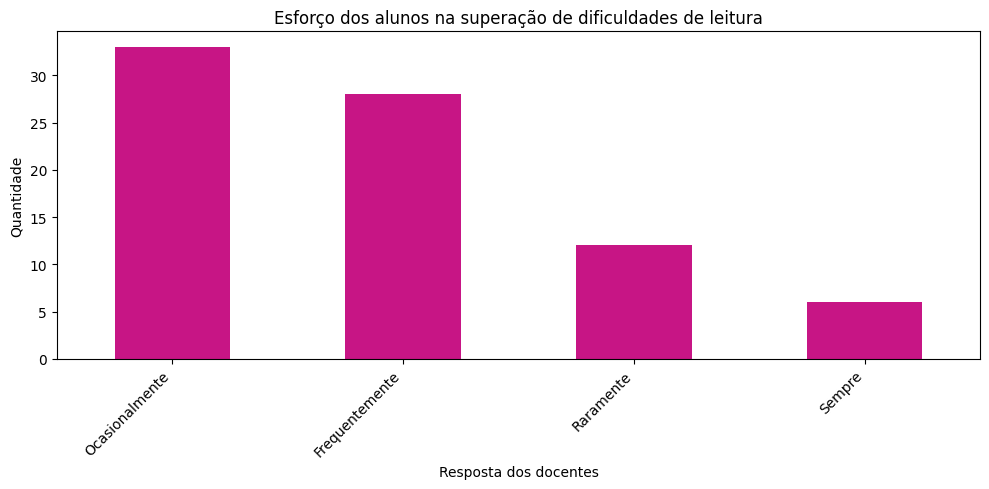

In [ ]:
# @title Quanto ao nível de leitura, demonstram esforço na superação de dificuldades?

# Nome exato da coluna com '\n' no final
coluna = 'Quanto ao nível de leitura, demonstram esforço na superação de dificuldades?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumvioletred')
plt.title('Esforço dos alunos na superação de dificuldades de leitura')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

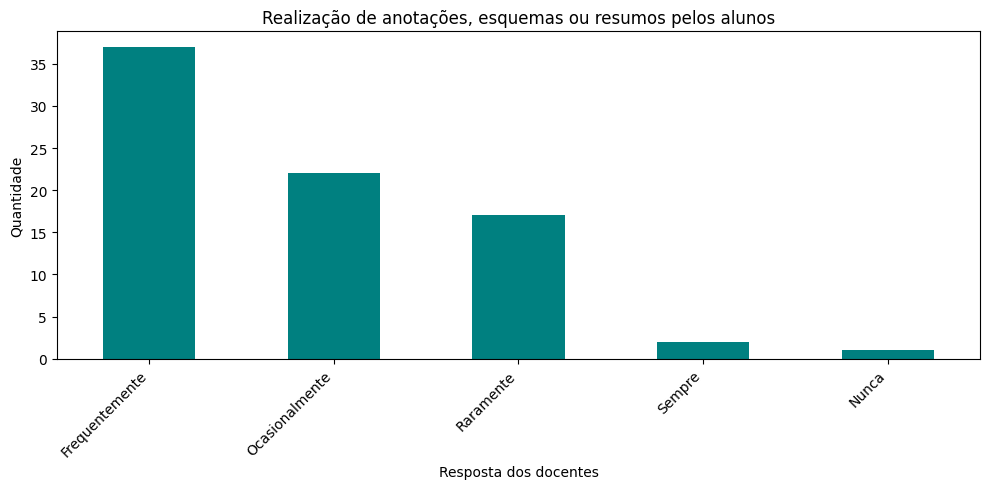

In [ ]:
# @title Os alunos fazem anotações, esquemas ou resumos das leituras indicadas?

# Nome exato da coluna com '\n' no final
coluna = 'Os alunos fazem anotações, esquemas ou resumos das leituras indicadas?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='teal')
plt.title('Realização de anotações, esquemas ou resumos pelos alunos')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

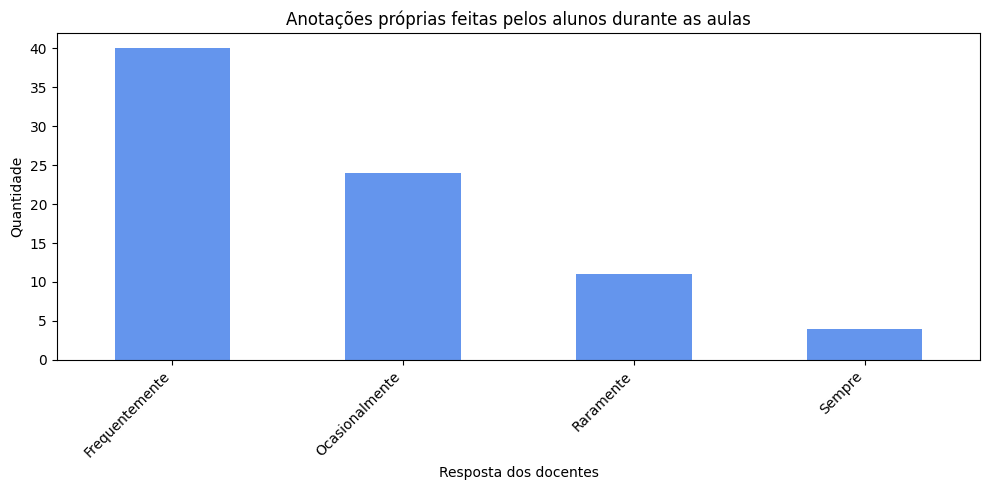

In [ ]:
# @title Os alunos fazem anotações próprias durante as aulas?

# Nome exato da coluna com '\n' no final
coluna = 'Os alunos fazem anotações próprias durante as aulas?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='cornflowerblue')
plt.title('Anotações próprias feitas pelos alunos durante as aulas')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

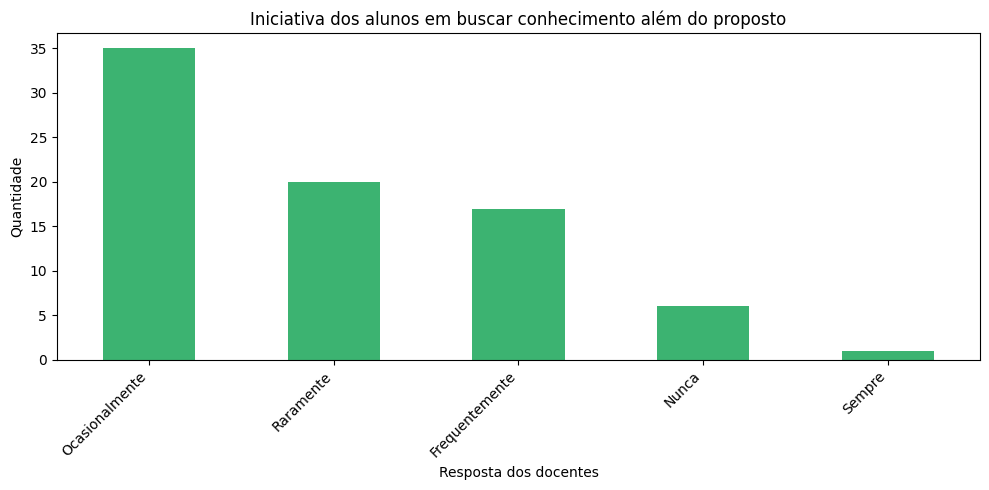

In [ ]:
# @title Os alunos demonstram iniciativa em buscar conhecimento além do que foi proposto?

# Nome exato da coluna com '\n' no final
coluna = 'Os alunos demonstram iniciativa em buscar conhecimento além do que foi proposto?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumseagreen')
plt.title('Iniciativa dos alunos em buscar conhecimento além do proposto')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

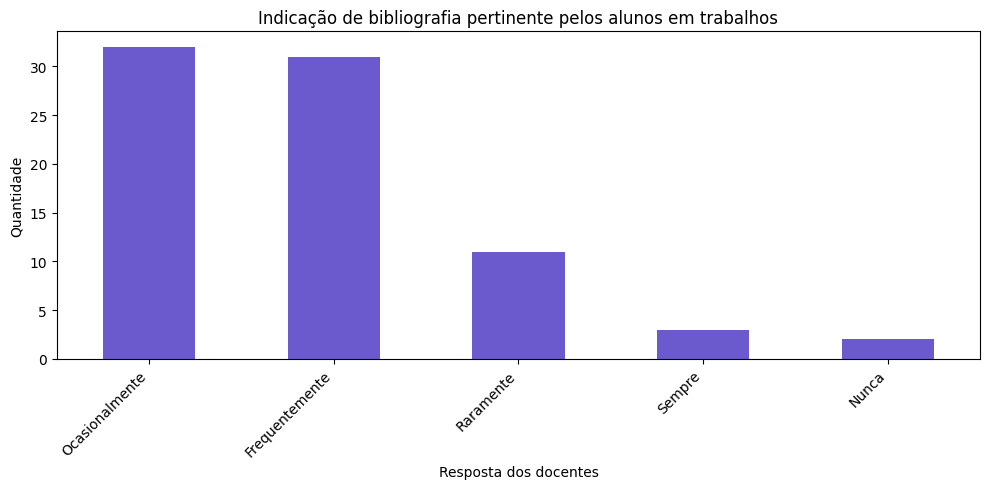

In [ ]:
# @title Na apresentação de trabalhos, costumam indicar bibliografia pertinente sobre o conteúdo?

# Nome exato da coluna com '\n' no final
coluna = 'Na apresentação de trabalhos, costumam indicar bibliografia pertinente sobre o conteúdo?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='slateblue')
plt.title('Indicação de bibliografia pertinente pelos alunos em trabalhos')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

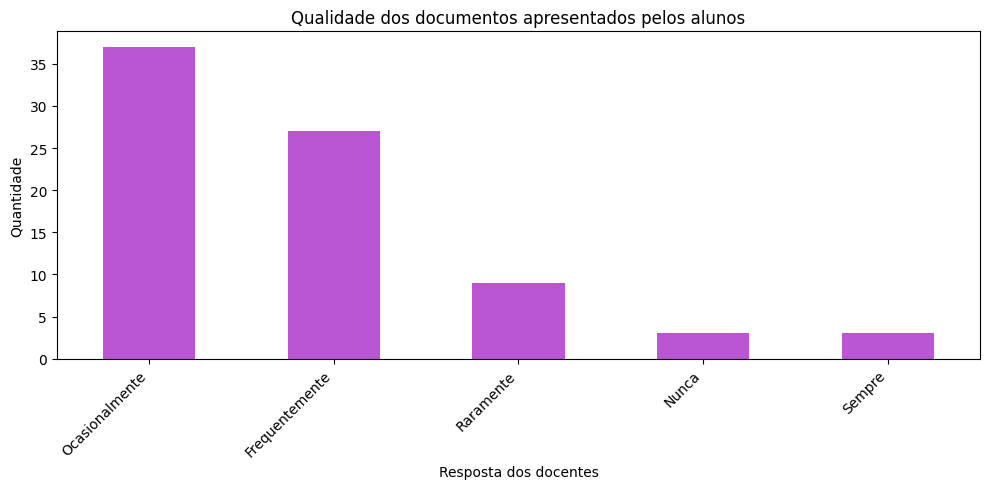

In [ ]:
# @title Ainda sobre a apresentação de trabalhos, os alunos costumam apresentar documentos em que são observadas questões estéticas, de redação, de organização e de normas da ABNT?

# Nome exato da coluna com '\n' no final
coluna = 'Ainda sobre a apresentação de trabalhos, os alunos costumam apresentar documentos em que são observadas questões estéticas, de redação, de organização e de normas da ABNT?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumorchid')
plt.title('Qualidade dos documentos apresentados pelos alunos')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

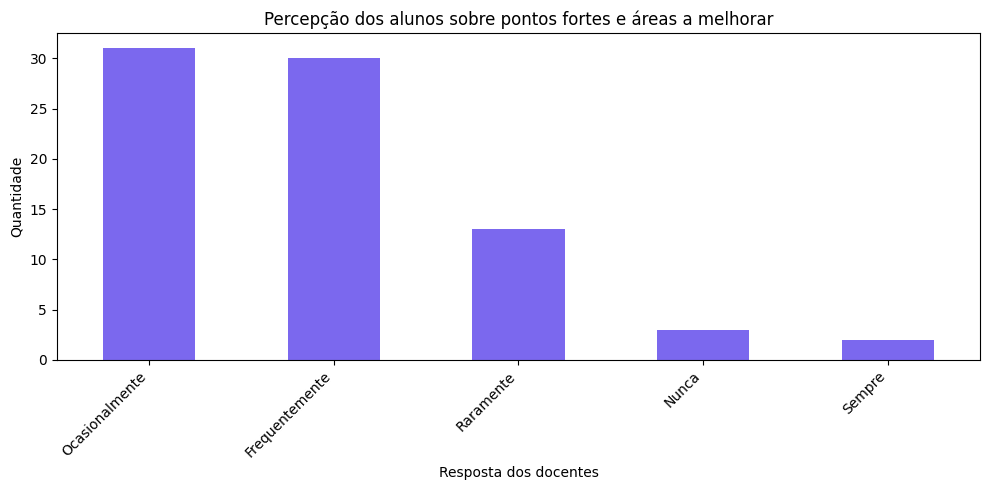

In [ ]:
# @title Na apresentação de resultados, seja de provas ou de trabalhos, os alunos demonstram percepção sobre pontos fortes e áreas a serem melhoradas?

# Nome exato da coluna com '\n' no final
coluna = 'Na apresentação de resultados, seja de provas ou de trabalhos, os alunos demonstram percepção sobre pontos fortes e áreas a serem melhoradas?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumslateblue')
plt.title('Percepção dos alunos sobre pontos fortes e áreas a melhorar')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

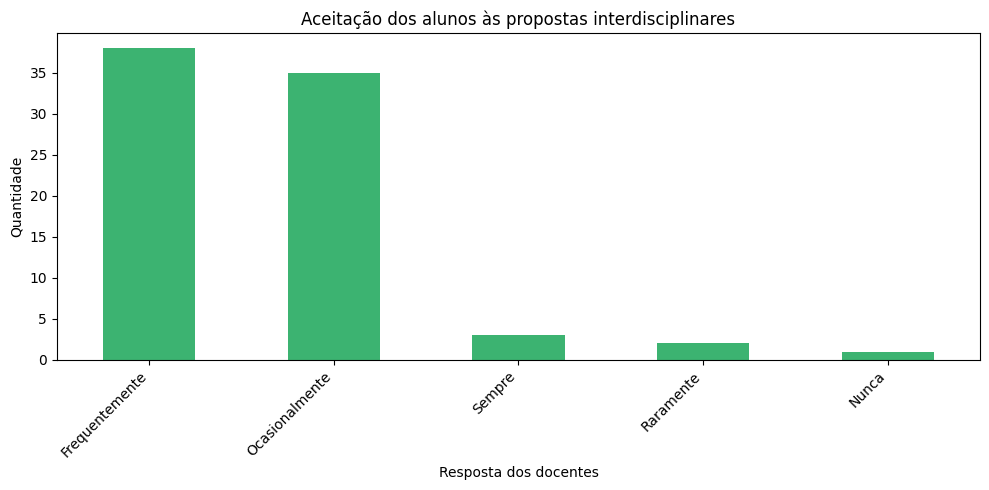

In [ ]:
# @title Os alunos acolhem bem, porque não questionam e porque entendem o propósito,  propostas de trabalho interdisciplinares, transdisciplinares e multidisciplinares?

# Nome exato da coluna com '\n' no final
coluna = 'Os alunos acolhem bem, porque não questionam e porque entendem o propósito,  propostas de trabalho interdisciplinares, transdisciplinares e multidisciplinares?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumseagreen')
plt.title('Aceitação dos alunos às propostas interdisciplinares')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

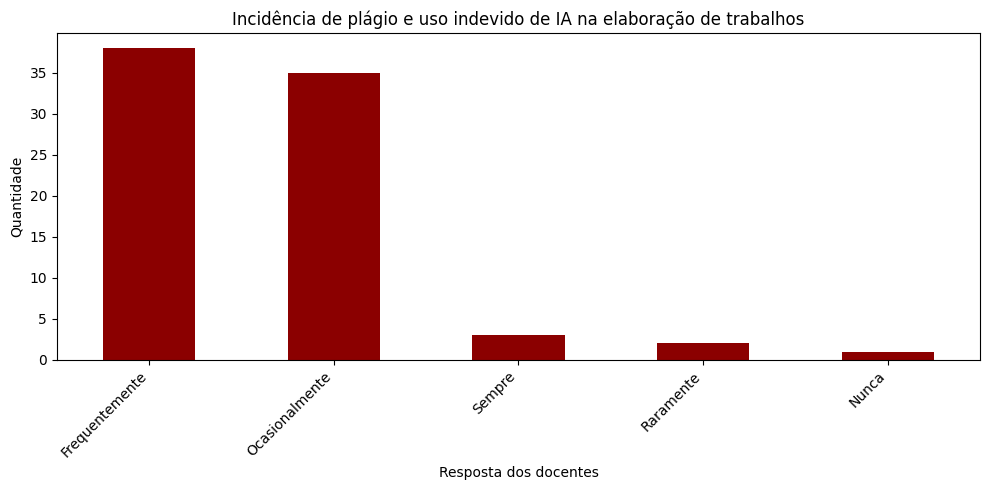

In [ ]:
# @title Você teve de lidar com plágio ou uso indevido de inteligência artificial na elaboração de trabalhos extraclasse? *Simplesmente copiar o texto gerado pela IA sem reelaboração crítica, porque envolve a geração de conteúdos sem autoria genuína, configura um uso indevido, especialmente se for apresentado como produção original. O problema central está na falta de autoria própria e no risco de plágio*

coluna = 'Você teve de lidar com plágio ou uso indevido de inteligência artificial* na elaboração de trabalhos extraclasse? * Simplesmente copiar o texto gerado pela IA sem reelaboração crítica, porque envolve a geração de conteúdos sem autoria genuína, configura um uso indevido, especialmente se for apresentado como produção original. O problema central está na falta de autoria própria e no risco de plágio.'

# Gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='darkred')
plt.title('Incidência de plágio e uso indevido de IA na elaboração de trabalhos')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


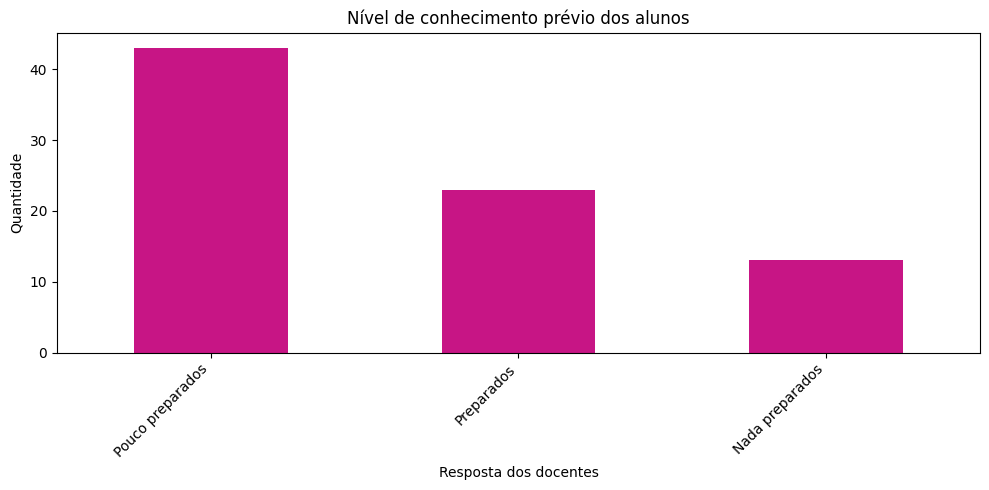

In [ ]:
# @title De acordo com sua percepção, qual o nível de conhecimento prévio dos alunos para acompanhar sua disciplina?

# Nome exato da coluna com '\n' no final
coluna = 'De acordo com sua percepção, qual o nível de conhecimento prévio dos alunos para acompanhar sua disciplina?'

# Contar as respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='mediumvioletred')
plt.title('Nível de conhecimento prévio dos alunos')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# @title Em quais aspectos da educação básica, no seu entendimento, os alunos apresentam maior dificuldade?

# Nome exato da coluna no DataFrame
coluna = 'Em quais aspectos da educação básica, no seu entendimento, os alunos apresentam maior dificuldade?'

# Função para limpar e padronizar cada resposta
def limpar_e_padronizar(resposta):
    if pd.isna(resposta):
        return []
    itens = [item.strip().rstrip('.') for item in resposta.split(',')]
    return [item for item in itens if item in categorias_oficiais]

# Extrai respostas não nulas
respostas = df[coluna].dropna()

# Inicializa contagem para cada categoria
contagem = {categoria: 0 for categoria in categorias_oficiais}

# Conta quantas vezes cada categoria aparece nas respostas
for resposta in respostas:
    categorias_marcadas = limpar_e_padronizar(resposta)
    for cat in categorias_marcadas:
        contagem[cat] += 1

# Cria DataFrame e ordena decrescente pela frequência
resultado = pd.DataFrame(
    list(contagem.items()), columns=['Categoria', 'Quantidade']
).sort_values(by='Quantidade', ascending=False)

# Exibe o DataFrame
print(resultado)

                                           Categoria  Quantidade
1         Leitura e interpretação de textos no geral          48
2       Leitura e interpretação de textos acadêmicos          42
0                        Gramática da língua materna          41
3       Elaboração e redação de trabalhos acadêmicos          39
5  Conhecimento prévio de conteúdos indispensávei...          39
4                     Raciocínio lógico e matemático          38
6       Capacidade de organização e estudo autônomos          21


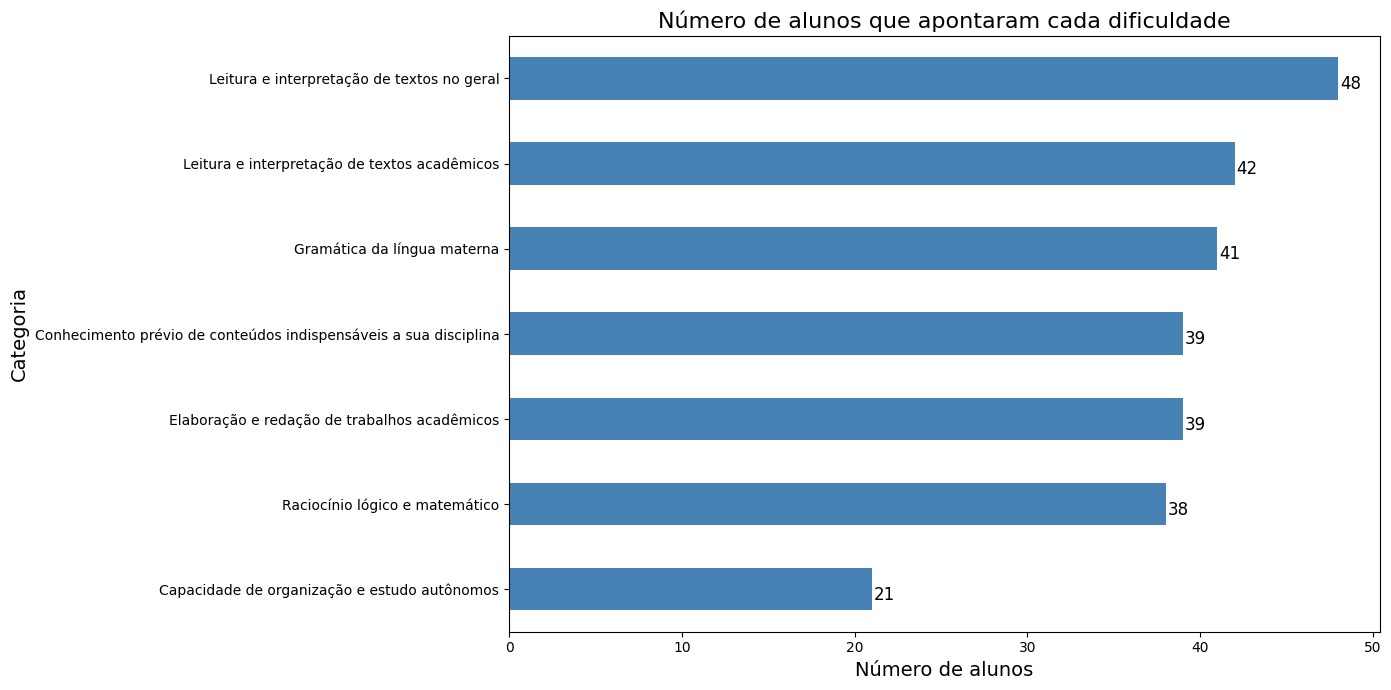

In [ ]:
# @title Em quais aspectos da educação básica, no seu entendimento, os alunos apresentam maior dificuldade?

# Lista oficial das categorias (padronização)
categorias_oficiais = [
    "Gramática da língua materna",
    "Leitura e interpretação de textos no geral",
    "Leitura e interpretação de textos acadêmicos",
    "Elaboração e redação de trabalhos acadêmicos",
    "Raciocínio lógico e matemático",
    "Conhecimento prévio de conteúdos indispensáveis a sua disciplina",
    "Capacidade de organização e estudo autônomos"
]

# Nome exato da coluna no DataFrame
coluna = 'Em quais aspectos da educação básica, no seu entendimento, os alunos apresentam maior dificuldade?'

# Função para limpar e padronizar uma resposta
def limpar_e_padronizar(resposta):
    # separa por vírgula, tira espaços e pontos finais
    itens = [item.strip().rstrip('.') for item in resposta.split(',')]
    # filtra só os que estão nas categorias oficiais
    return [item for item in itens if item in categorias_oficiais]

# Supondo que seu DataFrame já está carregado como df, com a coluna 'coluna'

# Aplica a função para transformar cada resposta em lista de categorias padronizadas
df['lista_categorias'] = df[coluna].apply(limpar_e_padronizar)

# Explode a lista para ter uma linha por categoria marcada por aluno
df_explodido = df.explode('lista_categorias')

# Conta quantos alunos marcaram cada categoria
contagem = df_explodido['lista_categorias'].value_counts().reindex(categorias_oficiais, fill_value=0)

# Ordena para plotar barras horizontais da menor para maior
contagem = contagem.sort_values(ascending=True)

# Plotar gráfico
plt.figure(figsize=(14, 7))
ax = contagem.plot(kind='barh', color='steelblue')
plt.title('Número de alunos que apontaram cada dificuldade', fontsize=16)
plt.xlabel('Número de alunos', fontsize=14)
plt.ylabel('Categoria', fontsize=14)

# Mostrar o valor numérico ao lado da barra
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + i.get_height()/4, str(int(i.get_width())), fontsize=12)

plt.tight_layout()
plt.show()

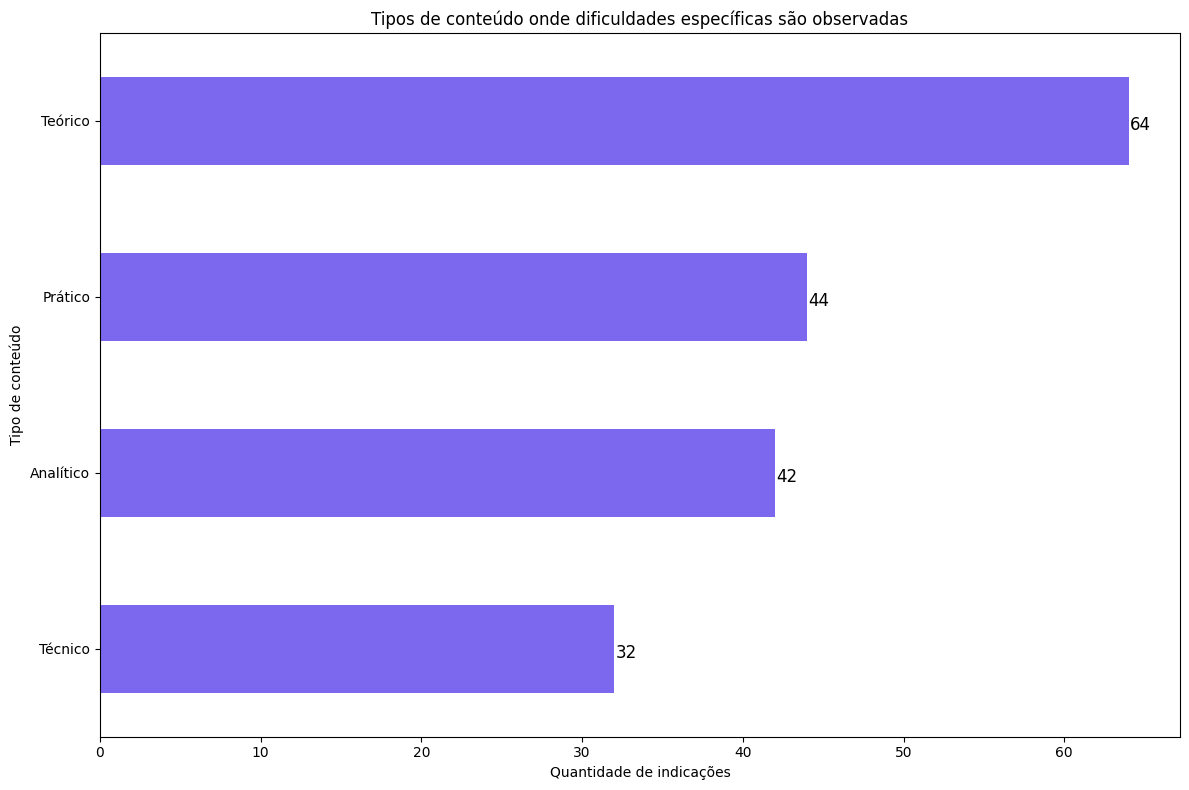

In [ ]:
# @title Essas dificuldades específicas são predominantemente observadas em relação a que tipo de conteúdo

# Nome exato da coluna (com '\n' se tiver, cheque antes)
coluna = 'Essas dificuldades específicas são predominantemente observadas em relação a que tipo de conteúdo:'

# Pegar respostas não nulas
respostas = df[coluna].dropna()

# Ajuste o separador conforme seu arquivo; aqui uso vírgula + espaço
respostas_separadas = respostas.str.split(', ')  # ou '; ' se for ponto e vírgula

# Explodir para linhas únicas
respostas_explodidas = respostas_separadas.explode().str.strip()

# Contar frequências
contagem = respostas_explodidas.value_counts()

# Gráfico horizontal para melhor leitura
plt.figure(figsize=(12,8))
ax = contagem.plot(kind='barh', color='mediumslateblue')
plt.title('Tipos de conteúdo onde dificuldades específicas são observadas')
plt.xlabel('Quantidade de indicações')
plt.ylabel('Tipo de conteúdo')
plt.gca().invert_yaxis()

# Mostrar valores nas barras
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.3, str(int(i.get_width())), fontsize=12)

plt.tight_layout()
plt.show()

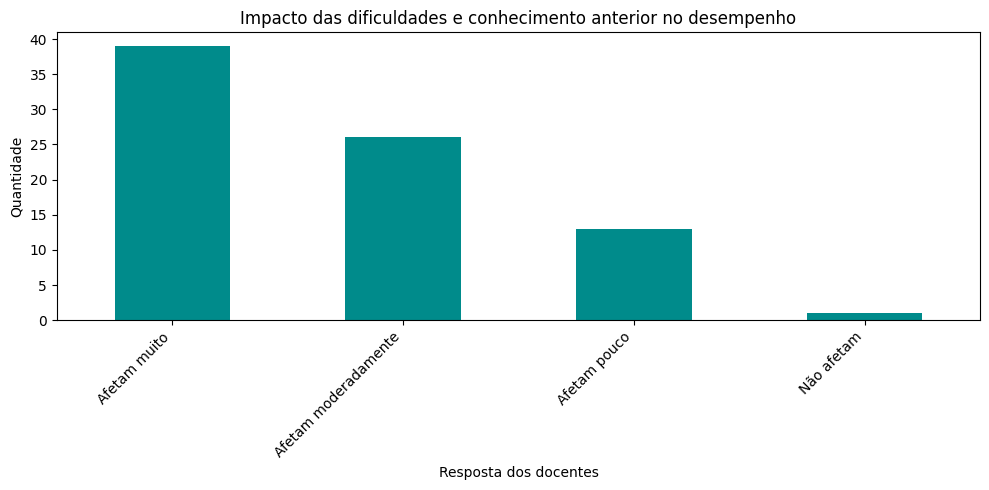

In [ ]:
# @title Em que medida essas dificuldades e o nível de conhecimento anterior afetam o desempenho em sua disciplina?

# Nome exato da coluna com \n, se tiver (confirme no df.columns)
coluna = 'Em que medida essas dificuldades e o nível de conhecimento anterior afetam o desempenho em sua disciplina?'

# Contar respostas
contagem_respostas = df[coluna].value_counts()

# Gráfico de barras
plt.figure(figsize=(10,5))
contagem_respostas.plot(kind='bar', color='darkcyan')
plt.title('Impacto das dificuldades e conhecimento anterior no desempenho')
plt.xlabel('Resposta dos docentes')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# @title Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina?'


# Lista fixa com todas as opções de desafios possíveis
desafios_possiveis = [
    'Falta de biblioteca atualizada às necessidades da disciplina',
    'Falta de infraestrutura ou recursos tecnológicos',
    'Dificuldade em equilibrar teoria e prática',
    'Dificuldade de adaptar a metodologia ao perfil dos alunos',
    'Temas e conteúdos complexos, muitas vezes de difícil compreensão por parte dos estudantes frente à precarização do ensino fundamental e médio',
    'Falta de tempo para preparar aulas de qualidade',
    'Carga horária pequena',
    'Organizar agenda de atividades extra classe',
    'Excesso de trabalho administrativo (relativo ao trabalho na instituição)',
    'Pouca interação e participação dos alunos',
    'A turma tem alunos que causam perturbação na aula e no atendimento dos colegas'
]

# Nome exato da coluna no DataFrame (com \n no final conforme você mostrou)
coluna = 'Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina?'

# Função para limpar e padronizar respostas
def limpar_e_padronizar(resposta):
    if pd.isna(resposta):
        return []
    itens = [item.strip().rstrip('.') for item in resposta.split(',')]
    return [item for item in itens if item in desafios_possiveis]

# Extrai respostas não nulas
respostas = df[coluna].dropna()

# Inicializa contagem para cada desafio
contagem = {desafio: 0 for desafio in desafios_possiveis}

# Conta quantas vezes cada desafio aparece nas respostas
for resposta in respostas:
    desafios_marcados = limpar_e_padronizar(resposta)
    for desafio in desafios_marcados:
        contagem[desafio] += 1

# Cria DataFrame e ordena decrescente pela frequência
resultado_desafios = pd.DataFrame(
    list(contagem.items()), columns=['Desafio', 'Quantidade']
).sort_values(by='Quantidade', ascending=False)

# Exibe o DataFrame
print(resultado_desafios)


                                              Desafio  Quantidade
1    Falta de infraestrutura ou recursos tecnológicos          45
0   Falta de biblioteca atualizada às necessidades...          42
9           Pouca interação e participação dos alunos          40
2          Dificuldade em equilibrar teoria e prática          14
3   Dificuldade de adaptar a metodologia ao perfil...          11
8   Excesso de trabalho administrativo (relativo a...          11
5     Falta de tempo para preparar aulas de qualidade           6
7         Organizar agenda de atividades extra classe           1
4   Temas e conteúdos complexos, muitas vezes de d...           0
6                               Carga horária pequena           0
10  A turma tem alunos que causam perturbação na a...           0


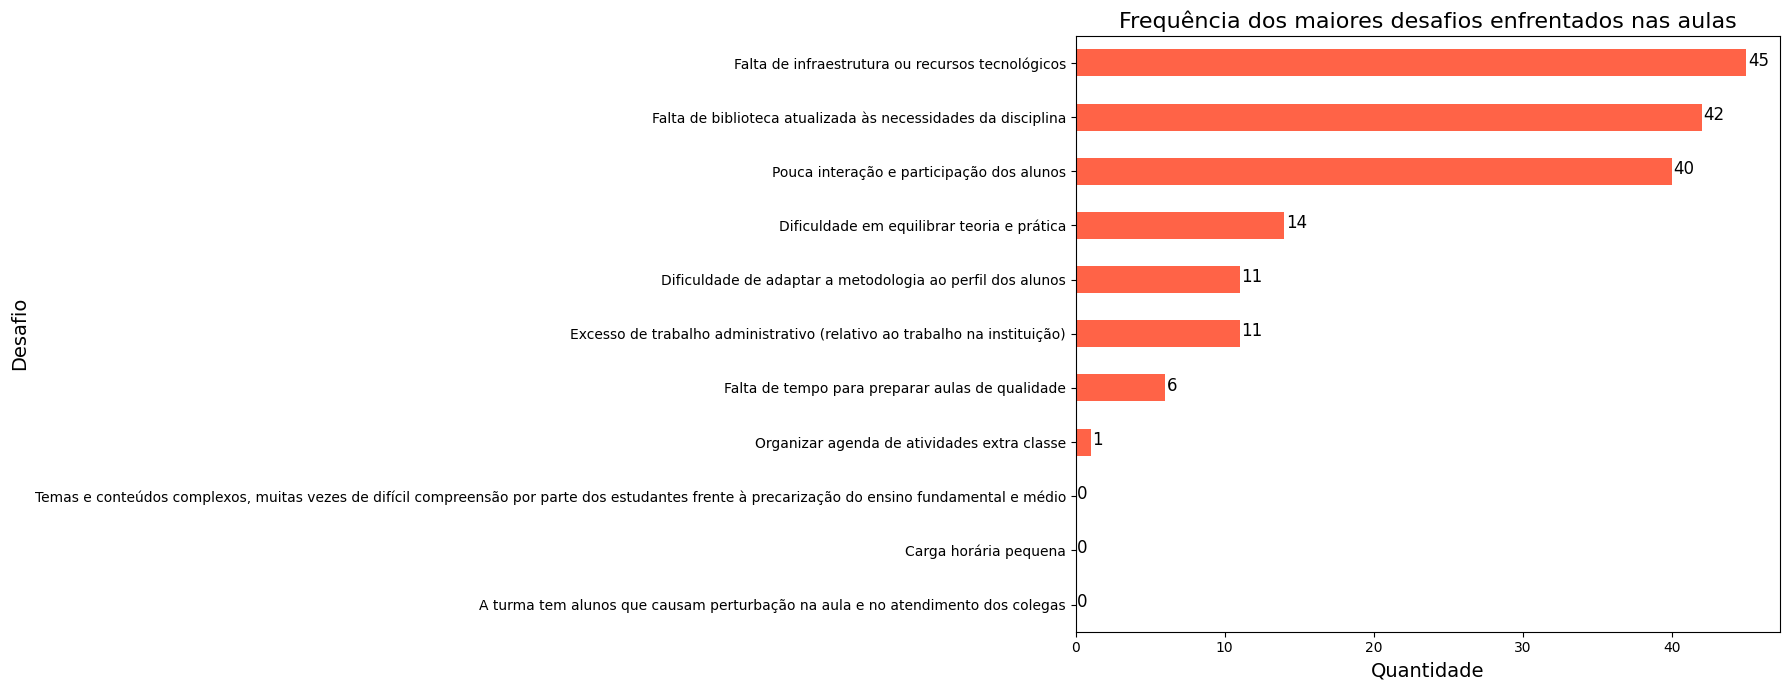

In [ ]:
# @title Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina?'

# Lista fixa com todas as opções de desafios possíveis
desafios_possiveis = [
    'Falta de biblioteca atualizada às necessidades da disciplina',
    'Falta de infraestrutura ou recursos tecnológicos',
    'Dificuldade em equilibrar teoria e prática',
    'Dificuldade de adaptar a metodologia ao perfil dos alunos',
    'Temas e conteúdos complexos, muitas vezes de difícil compreensão por parte dos estudantes frente à precarização do ensino fundamental e médio',
    'Falta de tempo para preparar aulas de qualidade',
    'Carga horária pequena',
    'Organizar agenda de atividades extra classe',
    'Excesso de trabalho administrativo (relativo ao trabalho na instituição)',
    'Pouca interação e participação dos alunos',
    'A turma tem alunos que causam perturbação na aula e no atendimento dos colegas'
]

# Nome da coluna no DataFrame
coluna = 'Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina?\n'

# Inicializar contagem
contagem = {desafio: 0 for desafio in desafios_possiveis}

# Contar ocorrências
for resposta in respostas:
    for desafio in desafios_possiveis:
        if desafio in resposta:
            contagem[desafio] += 1

# Converter em Series e ordenar (mais frequentes primeiro)
contagem_series = pd.Series(contagem).sort_values(ascending=False)

# Plotar gráfico de barras horizontais
plt.figure(figsize=(18, 7))
ax = contagem_series.plot(kind='barh', color='tomato')
plt.title('Frequência dos maiores desafios enfrentados nas aulas', fontsize=16)
plt.xlabel('Quantidade', fontsize=14)
plt.ylabel('Desafio', fontsize=14)
plt.gca().invert_yaxis()  # ✅ GARANTE que o maior fique no topo

# Adicionar valores ao lado das barras
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.3, str(int(i.get_width())), fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# @title Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina? (Análise de Sentimento com IA)

# -------------------------------
# 1. Análise de Sentimento
# -------------------------------

print("🔎 Análise de Sentimento:")

# Filtrar apenas respostas válidas: strings não vazias
respostas_validas = [str(r).strip() for r in respostas if isinstance(r, str) and len(r.strip()) > 0]

# Carregar modelo multilingue de sentimento
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Aplicar o modelo
resultados = sentiment_model(respostas_validas)

# Exibir os resultados
for texto, resultado in zip(respostas_validas, resultados):
    print(f"📝 Texto: {texto[:100]}...")
    print(f"📊 Sentimento: {resultado['label']} | Score: {resultado['score']:.2f}")
    print('-' * 50)


🔎 Análise de Sentimento:


Device set to use cpu


📝 Texto: carga horária pequena...
📊 Sentimento: 3 stars | Score: 0.42
--------------------------------------------------
📝 Texto: Dificuldade em equilibrar teoria e prática, Dificuldade de adaptar a metodologia ao perfil dos aluno...
📊 Sentimento: 2 stars | Score: 0.54
--------------------------------------------------
📝 Texto: Dificuldade em equilibrar teoria e prática, Falta de biblioteca atualizada às necessidades da discip...
📊 Sentimento: 2 stars | Score: 0.54
--------------------------------------------------
📝 Texto: Dificuldade em equilibrar teoria e prática, Falta de biblioteca atualizada às necessidades da discip...
📊 Sentimento: 2 stars | Score: 0.54
--------------------------------------------------
📝 Texto: Dificuldade em equilibrar teoria e prática, Falta de biblioteca atualizada às necessidades da discip...
📊 Sentimento: 2 stars | Score: 0.54
--------------------------------------------------
📝 Texto: Dificuldade em equilibrar teoria e prática, Falta de biblioteca atuali

Device set to use cpu


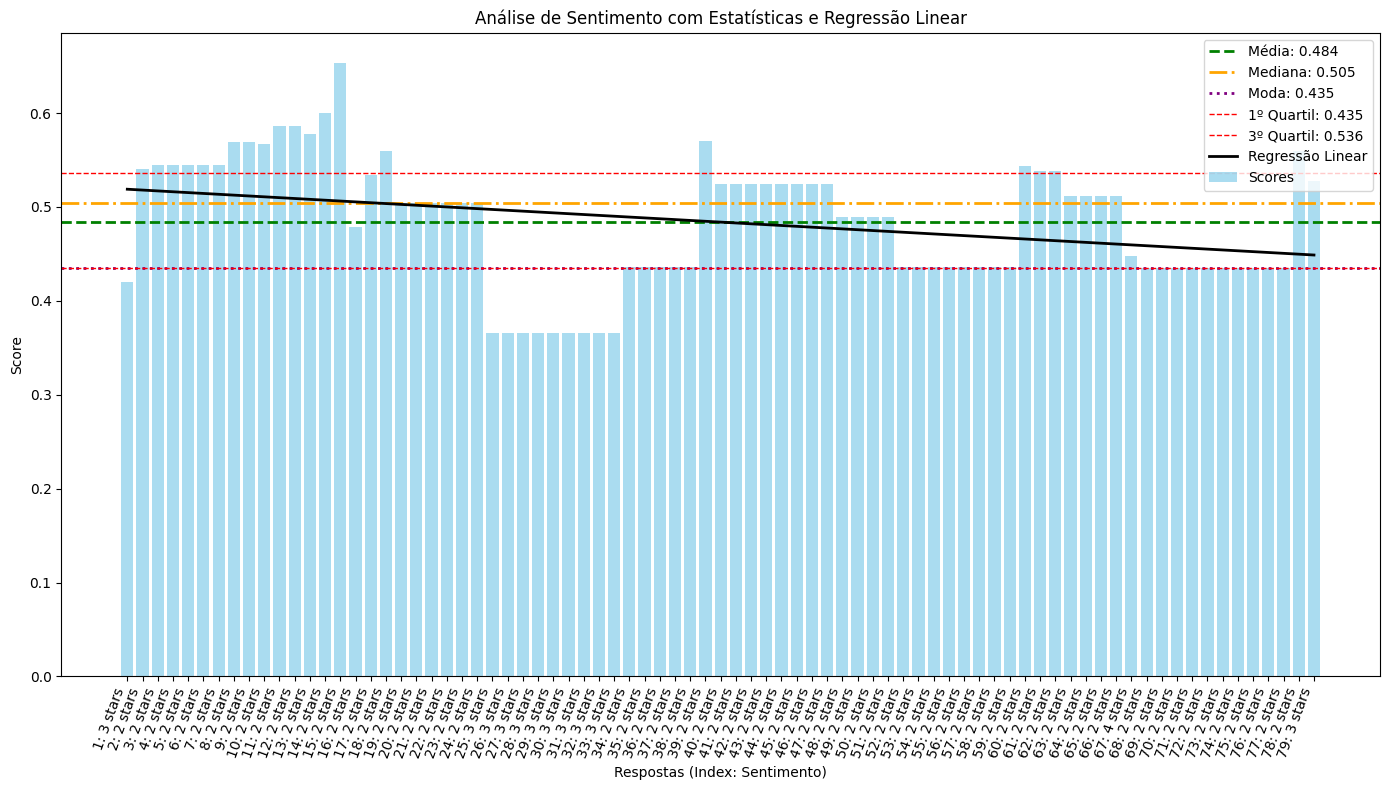

In [ ]:
# @title Análise de Sentimento com Estatísticas e Regressão Linear

# Supondo que 'respostas' é sua lista de respostas
respostas_validas = [str(r).strip() for r in respostas if isinstance(r, str) and len(r.strip()) > 0]

sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
resultados = sentiment_model(respostas_validas)

scores = [res['score'] for res in resultados]
labels = [res['label'] for res in resultados]

indices = np.arange(len(scores))

plt.figure(figsize=(14,8))

# Barras com scores
plt.bar(indices, scores, color='skyblue', alpha=0.7, label='Scores')

# Ajuste das legendas no eixo X (índice + label)
plt.xticks(indices, [f"{i+1}: {lab}" for i, lab in enumerate(labels)], rotation=70, ha='right')

# Estatísticas
media = mean(scores)
mediana_val = median(scores)
try:
    moda = mode(scores)
except StatisticsError:
    moda = None  # Caso não haja moda definida

quartil_1 = np.percentile(scores, 25)
quartil_3 = np.percentile(scores, 75)

# Linhas para as estatísticas
plt.axhline(media, color='green', linestyle='--', linewidth=2, label=f'Média: {media:.3f}')
plt.axhline(mediana_val, color='orange', linestyle='-.', linewidth=2, label=f'Mediana: {mediana_val:.3f}')
if moda is not None:
    plt.axhline(moda, color='purple', linestyle=':', linewidth=2, label=f'Moda: {moda:.3f}')
plt.axhline(quartil_1, color='red', linestyle='--', linewidth=1, label=f'1º Quartil: {quartil_1:.3f}')
plt.axhline(quartil_3, color='red', linestyle='--', linewidth=1, label=f'3º Quartil: {quartil_3:.3f}')

# Regressão linear
slope, intercept, r_value, p_value, std_err = linregress(indices, scores)
reg_line = intercept + slope * indices
plt.plot(indices, reg_line, color='black', linestyle='-', linewidth=2, label='Regressão Linear')

plt.xlabel('Respostas (Index: Sentimento)')
plt.ylabel('Score')
plt.title('Análise de Sentimento com Estatísticas e Regressão Linear')
plt.legend()
plt.tight_layout()
plt.show()

Device set to use cpu


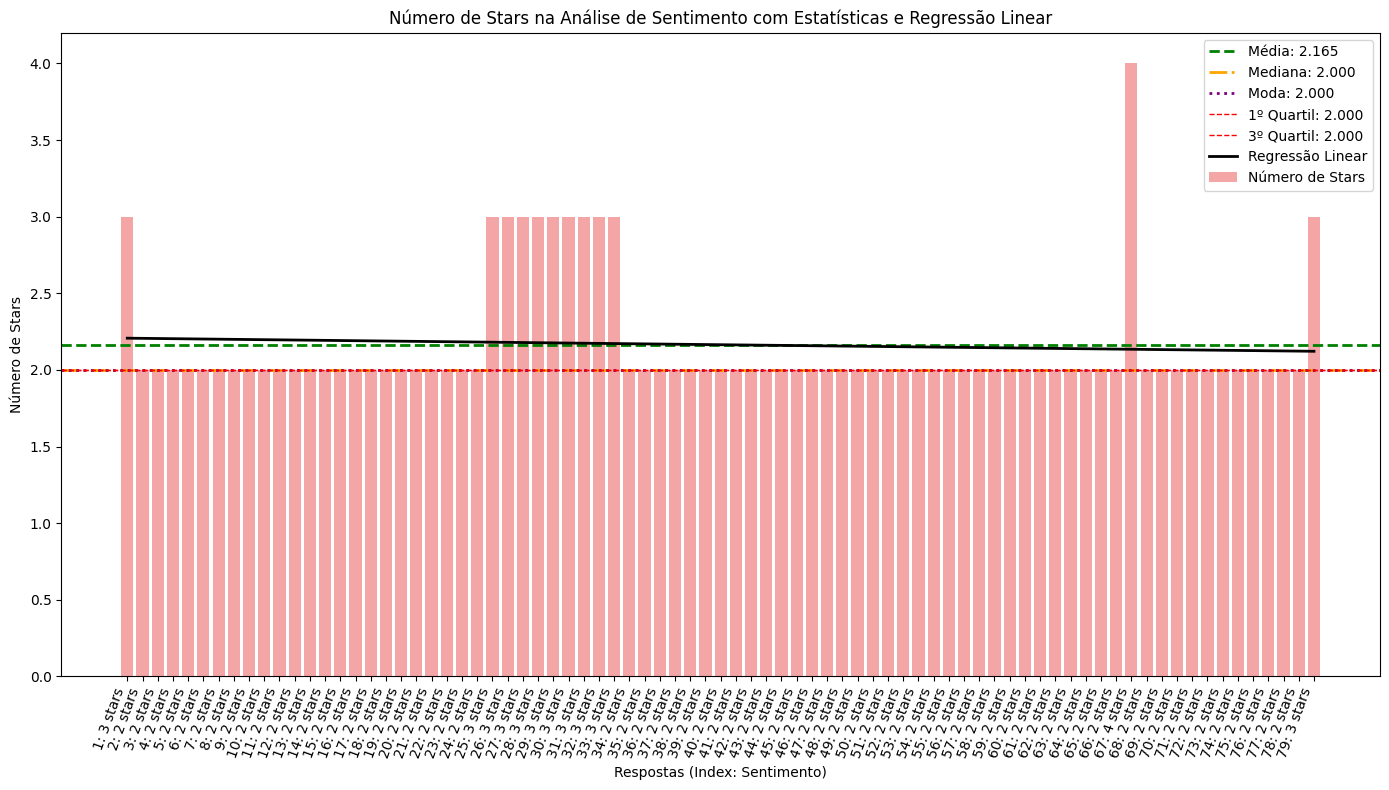

In [ ]:
# @title Número de Stars na Análise de Sentimento com Estatísticas e Regressão Linear

# Supondo que 'respostas' é sua lista de respostas
respostas_validas = [str(r).strip() for r in respostas if isinstance(r, str) and len(r.strip()) > 0]

sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
resultados = sentiment_model(respostas_validas)

# Extrair número de estrelas dos labels (ex: '4 stars' → 4)
def extrair_stars(label):
    match = re.search(r'(\d)', label)
    return int(match.group(1)) if match else None

stars = [extrair_stars(res['label']) for res in resultados]
indices = np.arange(len(stars))

plt.figure(figsize=(14,8))

# Barras com o número de estrelas
plt.bar(indices, stars, color='lightcoral', alpha=0.7, label='Número de Stars')

# Ajuste das legendas no eixo X (índice + label original)
labels_orig = [res['label'] for res in resultados]
plt.xticks(indices, [f"{i+1}: {lab}" for i, lab in enumerate(labels_orig)], rotation=70, ha='right')

# Estatísticas
media = mean(stars)
mediana_val = median(stars)
try:
    moda = mode(stars)
except StatisticsError:
    moda = None

quartil_1 = np.percentile(stars, 25)
quartil_3 = np.percentile(stars, 75)

# Linhas das estatísticas
plt.axhline(media, color='green', linestyle='--', linewidth=2, label=f'Média: {media:.3f}')
plt.axhline(mediana_val, color='orange', linestyle='-.', linewidth=2, label=f'Mediana: {mediana_val:.3f}')
if moda is not None:
    plt.axhline(moda, color='purple', linestyle=':', linewidth=2, label=f'Moda: {moda:.3f}')
plt.axhline(quartil_1, color='red', linestyle='--', linewidth=1, label=f'1º Quartil: {quartil_1:.3f}')
plt.axhline(quartil_3, color='red', linestyle='--', linewidth=1, label=f'3º Quartil: {quartil_3:.3f}')

# Regressão linear
slope, intercept, r_value, p_value, std_err = linregress(indices, stars)
reg_line = intercept + slope * indices
plt.plot(indices, reg_line, color='black', linestyle='-', linewidth=2, label='Regressão Linear')

plt.xlabel('Respostas (Index: Sentimento)')
plt.ylabel('Número de Stars')
plt.title('Número de Stars na Análise de Sentimento com Estatísticas e Regressão Linear')
plt.legend()
plt.tight_layout()
plt.show()

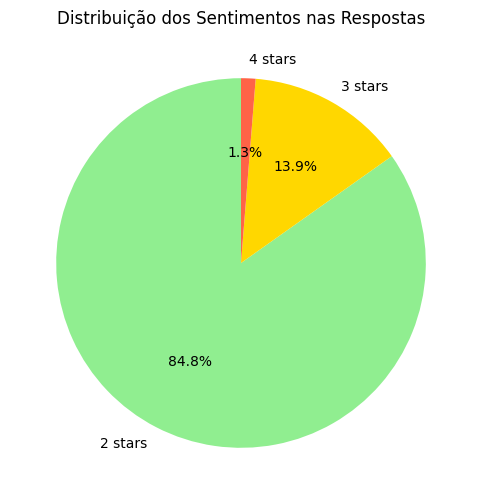

In [ ]:
# @title Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina? (Análise de Sentimento com IA)

# Contar categorias de sentimento
sentimentos = [r['label'] for r in resultados]
contagem = pd.Series(sentimentos).value_counts()

# Exibir gráfico de pizza
plt.figure(figsize=(6, 6))
contagem.plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'gold', 'tomato', 'skyblue', 'plum'])
plt.title("Distribuição dos Sentimentos nas Respostas")
plt.ylabel('')
plt.show()


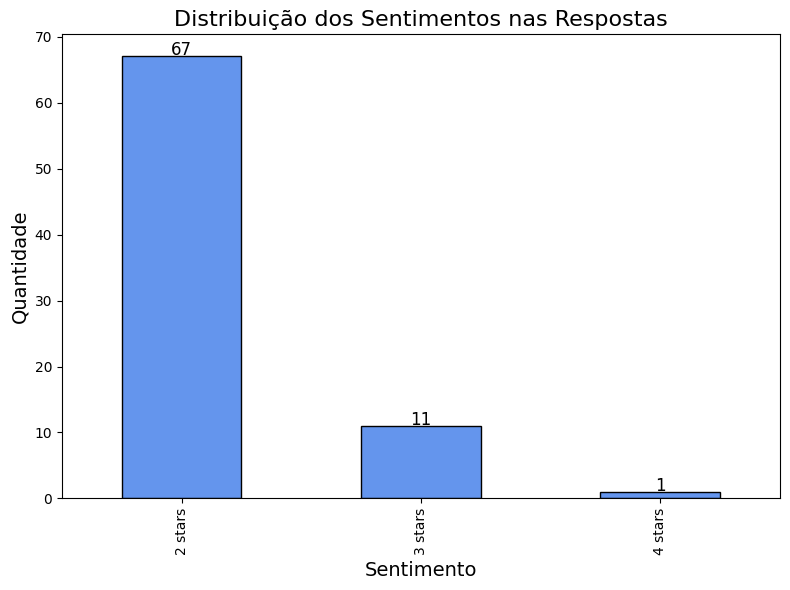

In [ ]:
# @title Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina? (Análise de Sentimento com IA)

# Contar categorias de sentimento
sentimentos = [r['label'] for r in resultados]
contagem = pd.Series(sentimentos).value_counts()

# Exibir gráfico de barras
plt.figure(figsize=(8, 6))
ax = contagem.plot(kind='bar', color='cornflowerblue', edgecolor='black')

plt.title("Distribuição dos Sentimentos nas Respostas", fontsize=16)
plt.xlabel("Sentimento", fontsize=14)
plt.ylabel("Quantidade", fontsize=14)

# Adiciona os valores acima das barras
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height() + 0.2, str(int(i.get_height())),
            ha='center', fontsize=12)

plt.tight_layout()
plt.show()


🌥️ Nuvem de Palavras:


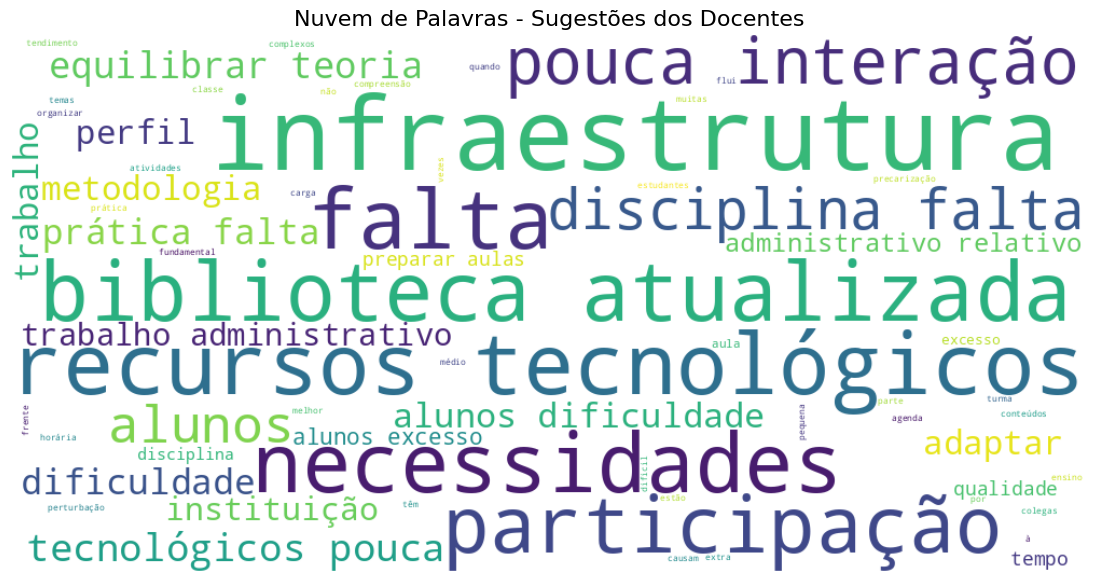

In [ ]:
# @title Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina? (Nuvem de Palavras)

# -------------------------------
# 2. Nuvem de Palavras
# -------------------------------
print("\n🌥️ Nuvem de Palavras:")

# Garantir que todas as respostas sejam texto e concatenar
respostas_texto = [str(r) for r in respostas if isinstance(r, str)]

# Unir tudo em um único texto
texto_completo = " ".join(respostas_texto).lower()

# Remover pontuações e caracteres especiais
texto_completo = re.sub(r'[^\w\s]', '', texto_completo)

# Stopwords personalizadas
stopwords_personalizadas = set(STOPWORDS).union({
    'de', 'e', 'a', 'o', 'que', 'os', 'as', 'em', 'para', 'com', 'da', 'do', 'nos', 'das', 'dos', 'na', 'no', 'se', 'ao', 'às', 'ou'})

# Gerar a nuvem
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis',
    stopwords=stopwords_personalizadas
).generate(texto_completo)

# Mostrar a nuvem
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Sugestões dos Docentes', fontsize=16)
plt.show()

In [ ]:
# @title Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras (Analise de Sentimento)

print("🔎 Análise de Sentimento para sugestões:")

# Suponha que 'df' é seu DataFrame pandas e essa é a coluna que quer analisar
coluna_sugestoes = 'Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.'

# Extrair respostas válidas da coluna
respostas_sugestoes = [str(r).strip() for r in df[coluna_sugestoes] if isinstance(r, str) and len(r.strip()) > 0]

# Carregar modelo multilingue de sentimento (se ainda não carregou)
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Aplicar o modelo
resultados_sugestoes = sentiment_model(respostas_sugestoes)

# Exibir os resultados
for texto, resultado in zip(respostas_sugestoes, resultados_sugestoes):
    print(f"📝 Texto: {texto[:100]}...")
    print(f"📊 Sentimento: {resultado['label']} | Score: {resultado['score']:.2f}")
    print('-' * 50)

🔎 Análise de Sentimento para sugestões:


Device set to use cpu


📝 Texto: A fim de garantir um resultado mais preciso nas estatísticas, sugiro o acréscimo da alternativa "Não...
📊 Sentimento: 2 stars | Score: 0.40
--------------------------------------------------
📝 Texto: Considero oportuno que haja critérios objetivos quanto o início e termino das aulas, pois há tendênc...
📊 Sentimento: 3 stars | Score: 0.52
--------------------------------------------------
📝 Texto: Há pergunas que não são aplicáveis, pois em uma disciplina optativa de Língua estrangeira de 1 semes...
📊 Sentimento: 1 star | Score: 0.46
--------------------------------------------------
📝 Texto: Há algumas perguntas, que não são aplicáveis a Língua estrangeira, principalmente com apenas 1 semes...
📊 Sentimento: 2 stars | Score: 0.41
--------------------------------------------------
📝 Texto: Os alunos tendem a chegar atrasados, comprometendo a dinâmica em sala de aula....
📊 Sentimento: 3 stars | Score: 0.59
--------------------------------------------------
📝 Texto: A disciplina O

Device set to use cpu


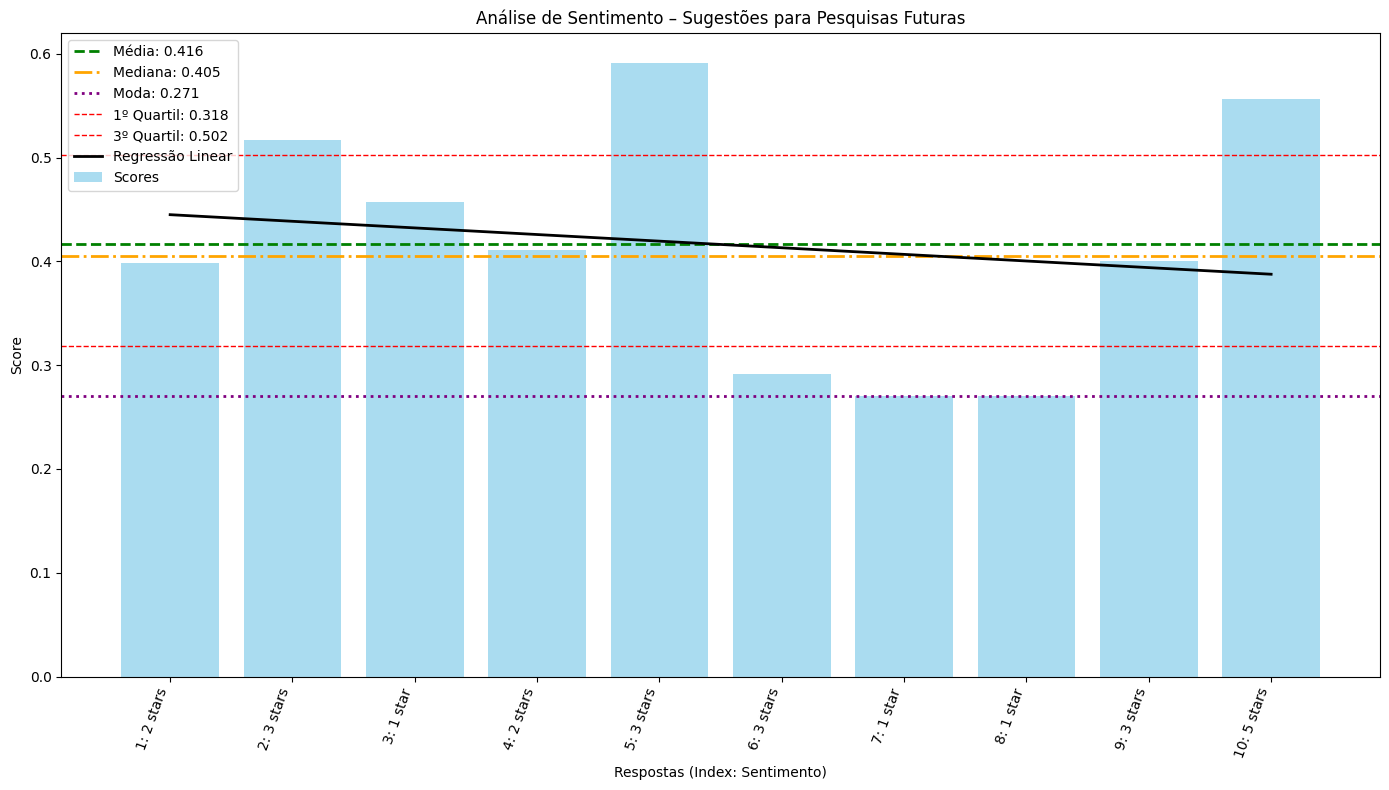

In [ ]:
# @title Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras

# Nome exato da coluna
coluna_sugestoes = 'Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.'

# 1. Filtrar respostas válidas da nova coluna
respostas = [str(r).strip() for r in df[coluna_sugestoes] if isinstance(r, str) and len(r.strip()) > 0]

# 2. Carregar o modelo de sentimento
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# 3. Aplicar o modelo
resultados = sentiment_model(respostas)

# 4. Extrair scores e labels
scores = [res['score'] for res in resultados]
labels = [res['label'] for res in resultados]
indices = np.arange(len(scores))

# 5. Criar gráfico
plt.figure(figsize=(14,8))
plt.bar(indices, scores, color='skyblue', alpha=0.7, label='Scores')
plt.xticks(indices, [f"{i+1}: {lab}" for i, lab in enumerate(labels)], rotation=70, ha='right')

# 6. Estatísticas
media = mean(scores)
mediana_val = median(scores)
try:
    moda = mode(scores)
except StatisticsError:
    moda = None  # Pode não haver moda

quartil_1 = np.percentile(scores, 25)
quartil_3 = np.percentile(scores, 75)

# 7. Linhas horizontais das estatísticas
plt.axhline(media, color='green', linestyle='--', linewidth=2, label=f'Média: {media:.3f}')
plt.axhline(mediana_val, color='orange', linestyle='-.', linewidth=2, label=f'Mediana: {mediana_val:.3f}')
if moda is not None:
    plt.axhline(moda, color='purple', linestyle=':', linewidth=2, label=f'Moda: {moda:.3f}')
plt.axhline(quartil_1, color='red', linestyle='--', linewidth=1, label=f'1º Quartil: {quartil_1:.3f}')
plt.axhline(quartil_3, color='red', linestyle='--', linewidth=1, label=f'3º Quartil: {quartil_3:.3f}')

# 8. Regressão linear
slope, intercept, r_value, p_value, std_err = linregress(indices, scores)
reg_line = intercept + slope * indices
plt.plot(indices, reg_line, color='black', linestyle='-', linewidth=2, label='Regressão Linear')

# 9. Configurações finais
plt.xlabel('Respostas (Index: Sentimento)')
plt.ylabel('Score')
plt.title('Análise de Sentimento – Sugestões para Pesquisas Futuras')
plt.legend()
plt.tight_layout()
plt.show()

Device set to use cpu


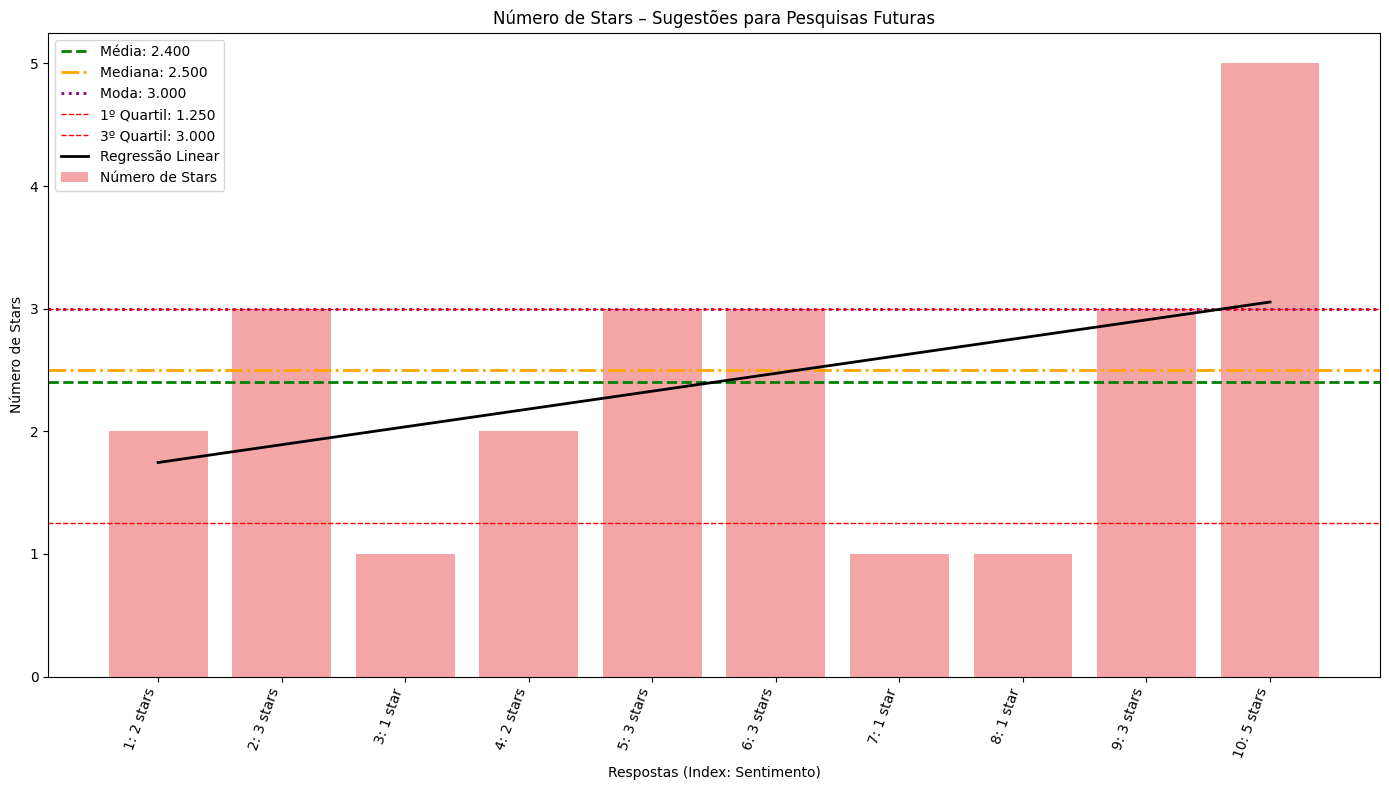

In [ ]:
# @title Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras

# Nome da coluna com as sugestões
coluna_sugestoes = 'Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.'

# 1. Filtrar respostas válidas
respostas = [str(r).strip() for r in df[coluna_sugestoes] if isinstance(r, str) and len(r.strip()) > 0]

# 2. Aplicar o modelo
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
resultados = sentiment_model(respostas)

# 3. Extrair número de estrelas do label (ex: "4 stars" → 4)
def extrair_stars(label):
    match = re.search(r'(\d)', label)
    return int(match.group(1)) if match else None

stars = [extrair_stars(res['label']) for res in resultados]
indices = np.arange(len(stars))
labels_orig = [res['label'] for res in resultados]

# 4. Plotar gráfico
plt.figure(figsize=(14,8))
plt.bar(indices, stars, color='lightcoral', alpha=0.7, label='Número de Stars')
plt.xticks(indices, [f"{i+1}: {lab}" for i, lab in enumerate(labels_orig)], rotation=70, ha='right')

# 5. Estatísticas
media = mean(stars)
mediana_val = median(stars)
try:
    moda = mode(stars)
except StatisticsError:
    moda = None

quartil_1 = np.percentile(stars, 25)
quartil_3 = np.percentile(stars, 75)

# 6. Linhas horizontais das estatísticas
plt.axhline(media, color='green', linestyle='--', linewidth=2, label=f'Média: {media:.3f}')
plt.axhline(mediana_val, color='orange', linestyle='-.', linewidth=2, label=f'Mediana: {mediana_val:.3f}')
if moda is not None:
    plt.axhline(moda, color='purple', linestyle=':', linewidth=2, label=f'Moda: {moda:.3f}')
plt.axhline(quartil_1, color='red', linestyle='--', linewidth=1, label=f'1º Quartil: {quartil_1:.3f}')
plt.axhline(quartil_3, color='red', linestyle='--', linewidth=1, label=f'3º Quartil: {quartil_3:.3f}')

# 7. Regressão linear
slope, intercept, r_value, p_value, std_err = linregress(indices, stars)
reg_line = intercept + slope * indices
plt.plot(indices, reg_line, color='black', linestyle='-', linewidth=2, label='Regressão Linear')

# 8. Título e eixos
plt.xlabel('Respostas (Index: Sentimento)')
plt.ylabel('Número de Stars')
plt.title('Número de Stars – Sugestões para Pesquisas Futuras')
plt.legend()
plt.tight_layout()
plt.show()

Device set to use cpu


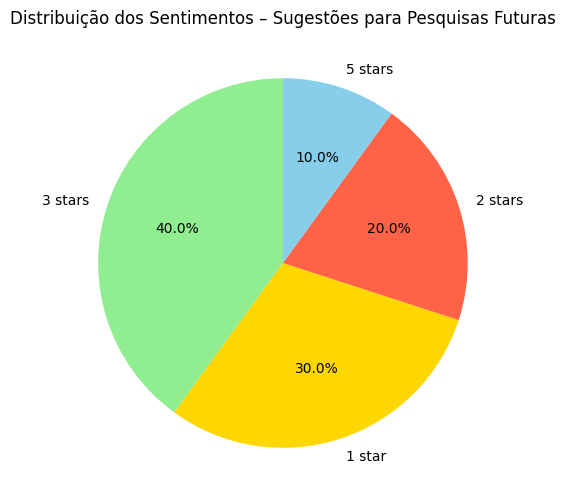

In [ ]:
# @title Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras

# Nome exato da coluna com sugestões
coluna_sugestoes = 'Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.'

# Filtrar respostas válidas (não vazias)
respostas_sugestoes = [str(r).strip() for r in df[coluna_sugestoes] if isinstance(r, str) and len(r.strip()) > 0]

# Carregar o modelo se ainda não carregou
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Aplicar a análise de sentimento
resultados_sugestoes = sentiment_model(respostas_sugestoes)

# Contar categorias de sentimento
sentimentos_sugestoes = [r['label'] for r in resultados_sugestoes]
contagem_sugestoes = pd.Series(sentimentos_sugestoes).value_counts()

# Exibir gráfico de pizza
plt.figure(figsize=(6, 6))
contagem_sugestoes.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgreen', 'gold', 'tomato', 'skyblue', 'plum']
)
plt.title("Distribuição dos Sentimentos – Sugestões para Pesquisas Futuras")
plt.ylabel('')
plt.show()

Device set to use cpu


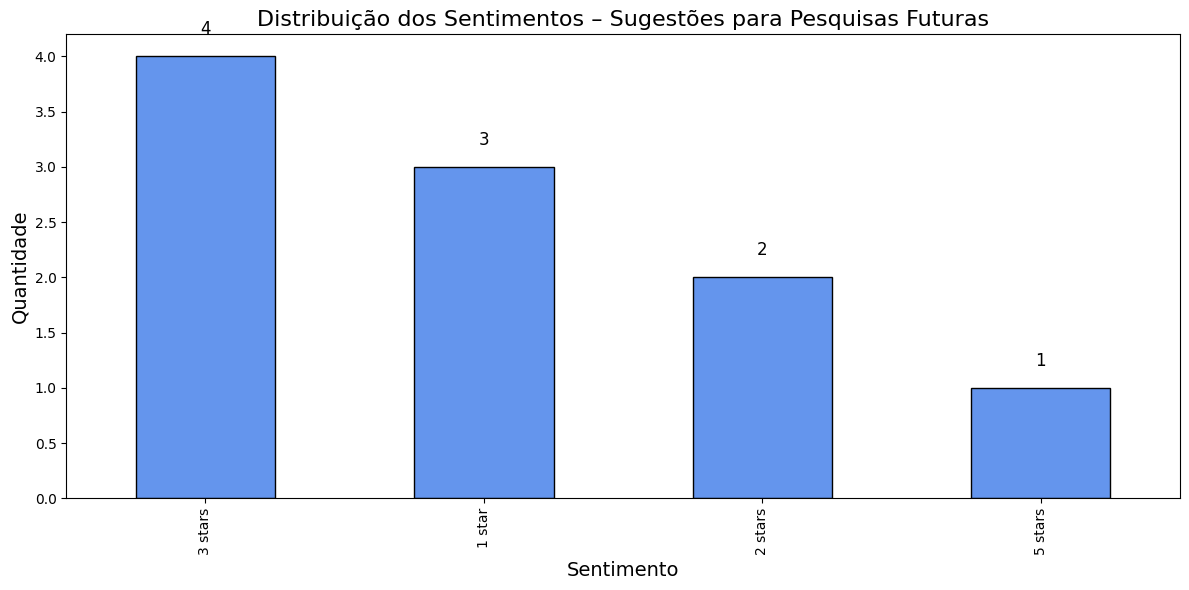

In [ ]:
# @title Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras

# Nome da coluna com sugestões
coluna_sugestoes = 'Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.'

# Filtrar respostas válidas
respostas_sugestoes = [str(r).strip() for r in df[coluna_sugestoes] if isinstance(r, str) and len(r.strip()) > 0]

# Carregar modelo se necessário
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Aplicar o modelo
resultados_sugestoes = sentiment_model(respostas_sugestoes)

# Contar categorias de sentimento
sentimentos_sugestoes = [r['label'] for r in resultados_sugestoes]
contagem_sugestoes = pd.Series(sentimentos_sugestoes).value_counts()

# Exibir gráfico de barras
plt.figure(figsize=(12, 6))
ax = contagem_sugestoes.plot(kind='bar', color='cornflowerblue', edgecolor='black')

plt.title("Distribuição dos Sentimentos – Sugestões para Pesquisas Futuras", fontsize=16)
plt.xlabel("Sentimento", fontsize=14)
plt.ylabel("Quantidade", fontsize=14)

# Adicionar valores acima das barras
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height() + 0.2, str(int(i.get_height())),
            ha='center', fontsize=12)

plt.tight_layout()
plt.show()

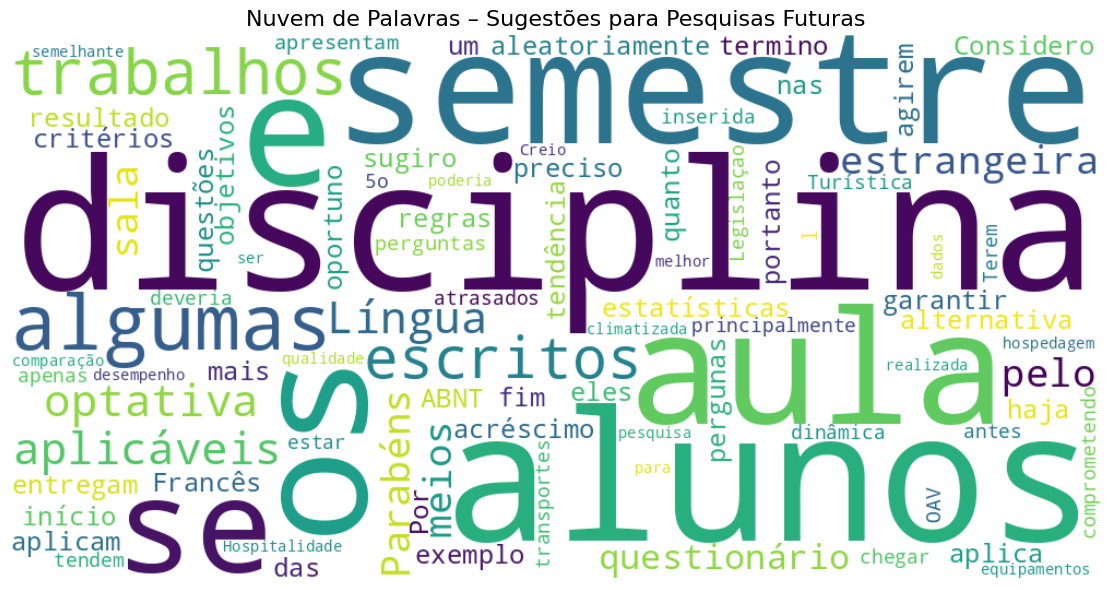

In [ ]:
# @title Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras


# Nome da coluna
coluna_sugestoes = 'Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.'

# Filtrar textos válidos
respostas_sugestoes = [str(r).strip() for r in df[coluna_sugestoes] if isinstance(r, str) and len(r.strip()) > 0]

# Juntar todos os textos em uma única string
texto_unico = " ".join(respostas_sugestoes)

# Stopwords padrão (pode adicionar outras específicas se quiser)
stopwords = set(STOPWORDS)
stopwords.update(['não','em','há','na', 'de', 'que', 'o','pois','uma','da','são'])  # Adicione mais se necessário


# Gerar nuvem de palavras
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=stopwords,
    collocations=True,
    colormap='viridis'
).generate(texto_unico)

# Exibir
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras – Sugestões para Pesquisas Futuras", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# @title Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras (Resumo gerado por IA)

# Inicializa o modelo de sumarização
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Nome da coluna
coluna_sugestoes = 'Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.'

# Extrair respostas válidas
respostas_sugestoes = [str(r).strip() for r in df[coluna_sugestoes] if isinstance(r, str) and len(r.strip()) > 0]

# Concatenar todas as respostas em um texto único
texto_total = " ".join(respostas_sugestoes)

# Dividir o texto em pedaços menores (chunks) para não ultrapassar o limite do modelo
tamanho_chunk = 1000  # pode ajustar para 500 ou 1500 se necessário
chunks = textwrap.wrap(texto_total, tamanho_chunk)

# Lista para armazenar os resumos de cada parte
resumos = []

for i, chunk in enumerate(chunks):
    print(f"Resumindo parte {i+1} de {len(chunks)}...")
    resumo_chunk = summarizer(chunk, max_length=160, min_length=40, do_sample=False)
    resumos.append(resumo_chunk[0]['summary_text'])

# Juntar os resumos das partes em um resumo final
resumo_final = " ".join(resumos)

print("\n📌 Resumo geral das sugestões para futuras pesquisas:")
print(resumo_final)

Device set to use cpu


Resumindo parte 1 de 2...


Your max_length is set to 160, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Resumindo parte 2 de 2...

📌 Resumo geral das sugestões para futuras pesquisas:
A disciplina OAV deveria estar inserida no 5o.semestre. Terem antes, meios de transportes, l Legislaçao Turística, Hospitalidade. Parabéns pelo questionário Creio que uma pesquisa semelhante poderia ser. Sala de aula climatizada, equipamentos de melhor qualidade e desempenho. realizada with os alunos para a comparação de dados.


In [ ]:
# @title Topicos semelhantes nos comentários dos docentes (Gerado por IA)

# 🔹 2. NOME DA COLUNA
coluna_sugestoes = 'Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.'

# 🔹 3. FILTRAR RESPOSTAS VÁLIDAS
respostas_limpo = [str(r).strip() for r in df[coluna_sugestoes] if isinstance(r, str) and r.strip() != ""]

# 🔹 4. VETORIZAÇÃO COM TF-IDF
# Removemos "para" da lista de stopwords
vectorizer = TfidfVectorizer(
    stop_words=["de", "e", "a", "o", "que", "os", "as", "em", "com", "não", "uma", "são", "pois", "pelo", "são", "há"],  # <- "para" foi removido aqui
    min_df=2  # ignora termos muito raros
)
X = vectorizer.fit_transform(respostas_limpo)

# 🔹 5. APLICAR K-MEANS
k = 4  # número de clusters (ajuste se quiser)
modelo = KMeans(n_clusters=k, random_state=42, n_init='auto')
modelo.fit(X)

# 🔹 6. EXIBIR TÓPICOS
termos = vectorizer.get_feature_names_out()
order_centroids = modelo.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    print(f"\n🔹 Tópico {i+1}:")
    print(", ".join(termos[ind] for ind in order_centroids[i, :10]))


🔹 Tópico 1:
semestre, disciplina, aplicáveis, estrangeira, língua, optativa, algumas, escritos, trabalhos, sala

🔹 Tópico 2:
alunos, trabalhos, sala, questionário, parabéns, semestre, optativa, língua, escritos, estrangeira

🔹 Tópico 3:
sala, aula, alunos, escritos, algumas, trabalhos, disciplina, parabéns, questionário, semestre

🔹 Tópico 4:
parabéns, questionário, semestre, trabalhos, sala, optativa, língua, estrangeira, escritos, disciplina


In [ ]:
# @title Cabeçalho do Dataframe
for col in df.columns:
    print(repr(col))

'Carimbo de data/hora'
'Endereço de e-mail'
'Nome completo'
'Disciplina ministrada (escrever o nome por extenso)'
'Semestre'
'Turno'
'Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?'
'Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?'
'Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar?'
'Na situação em que houve apenas aula de sua disciplina em uma determinada data, já ocorreu de os alunos se ausentarem de sua aula porque não haveria aula de outro professor?'
'Existem discentes que costumam entrar ou querer entrar atrasados nas aulas?'
'Você já enfrentou situações em que os alunos tentam burlar faltas e atrasos, ignorando completamente as normas?'
'Em caso de atraso, comportam-se de maneira respeitosa?'
'Ainda sobre ausências e pontualidade, embora o professor tenha plena au

In [ ]:
# @title DataFrame para Analise com IA
# Exibir o DataFrame completo
display(df)

Carimbo de data/hora                  Endereço de e-mail                          Nome completo Disciplina ministrada (escrever o nome por extenso) Semestre       Turno Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações? Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas? Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar? Na situação em que houve apenas aula de sua disciplina em uma determinada data, já ocorreu de os alunos se ausentarem de sua aula porque não haveria aula de outro professor? Existem discentes que costumam entrar ou querer entrar atrasados nas aulas? Você já enfrentou situações em que os alunos tentam burlar faltas e atrasos, ignorando completamente as normas? Em caso de atraso, comportam-se de maneira respeitosa? Ainda sobre ausências e pontualidade, embora o professor tenha plena autonomia em sala de aula, você consideraria positivo haver uma regra geral, instituída no curso, para tolerância de atrasos? Em geral, os alunos entregam projetos e trabalhos dentro do prazo? Quanto a atitudes DESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano: Quanto a atitudes INDESEJÁVEIS, assinale abaixo as que mais são observadas no cotidiano: Os alunos mostram-se cientes dos objetivos, do planejamento das aulas e dos métodos de avaliação informados no início do semestre letivo? Acredita haver por parte dos alunos um comprometimento com a própria formação e não apenas com a aprovação na disciplina? Caso seja solicitado, os alunos fazem as atividades práticas propostas em tempo extraclasse? Os alunos leem os textos acadêmicos e/ou didáticos indicados na disciplina? Quanto ao nível de leitura, demonstram esforço na superação de dificuldades? Os alunos fazem anotações, esquemas ou resumos das leituras indicadas? Os alunos fazem anotações próprias durante as aulas? Os alunos demonstram iniciativa em buscar conhecimento além do que foi proposto? Na apresentação de trabalhos, costumam indicar bibliografia pertinente sobre o conteúdo? Ainda sobre a apresentação de trabalhos, os alunos costumam apresentar documentos em que são observadas questões estéticas, de redação, de organização e de normas da ABNT? Na apresentação de resultados, seja de provas ou de trabalhos, os alunos demonstram percepção sobre pontos fortes e áreas a serem melhoradas? Os alunos acolhem bem, porque não questionam e porque entendem o propósito,  propostas de trabalho interdisciplinares, transdisciplinares e multidisciplinares? Você teve de lidar com plágio ou uso indevido de inteligência artificial* na elaboração de trabalhos extraclasse? \n* Simplesmente copiar o texto gerado pela IA sem reelaboração crítica, porque envolve a geração de conteúdos sem autoria genuína, configura De acordo com sua percepção, qual o nível de conhecimento prévio dos alunos para acompanhar sua disciplina? Em quais aspectos da educação básica, no seu entendimento, os alunos apresentam maior dificuldade? Essas dificuldades específicas são predominantemente observadas em relação a que tipo de conteúdo: Em que medida essas dificuldades e o nível de conhecimento anterior afetam o desempenho em sua disciplina? Quais são os maiores desafios que você enfrenta na condução de suas aulas nessa disciplina? Considere acrescentar informações ou sugestões para a pesquisa atual ou para pesquisas futuras.                DataHora DataFormatada  Hora    Periodo                                   lista_categorias
0   2025-03-09 20:49:55.251                   scunha@fatecsp.br                Sérgio Cunha dos Santos                                            Francês        6º  Vespertino                                             Sempre                                                                               Frequentemente                                                        

from matplotlib import pyplot as plt
df['Hora'].plot(kind='hist', bins=20, title='Hora')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Semestre').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Turno').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DataHora']
  ys = series['Hora']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('DataHora', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Semestre')):
  _plot_series(series, series_name, i)
  fig.legend(title='Semestre', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DataHora')
_ = plt.ylabel('Hora')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DataHora']
  ys = series['Hora']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('DataHora', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Turno')):
  _plot_series(series, series_name, i)
  fig.legend(title='Turno', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DataHora')
_ = plt.ylabel('Hora')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DataHora']
  ys = series['Hora']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('DataHora', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?')):
  _plot_series(series, series_name, i)
  fig.legend(title='Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DataHora')
_ = plt.ylabel('Hora')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DataHora']
  ys = series['Hora']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('DataHora', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?')):
  _plot_series(series, series_name, i)
  fig.legend(title='Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DataHora')
_ = plt.ylabel('Hora')

from matplotlib import pyplot as plt
df['Hora'].plot(kind='line', figsize=(8, 4), title='Hora')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Turno'].value_counts()
    for x_label, grp in df.groupby('Semestre')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Semestre')
_ = plt.ylabel('Turno')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?'].value_counts()
    for x_label, grp in df.groupby('Turno')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Turno')
_ = plt.ylabel('Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?'].value_counts()
    for x_label, grp in df.groupby('Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?')
_ = plt.ylabel('Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar?'].value_counts()
    for x_label, grp in df.groupby('Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?')
_ = plt.ylabel('Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar?')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Semestre'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Hora', y='Semestre', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Turno'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Hora', y='Turno', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Hora', y='Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Hora', y='Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-500-734639510.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Hora', y='Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?', inner='stick', palette='Dark2')


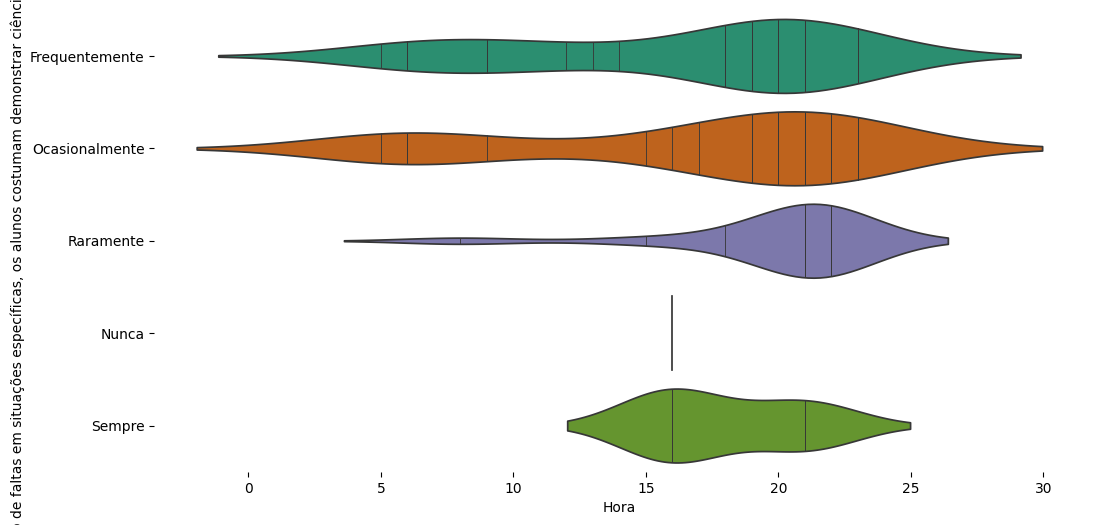

In [ ]:
# @title Distribuição horária das percepções sobre o abono de faltas conforme o regimento

figsize = (12, 1.2 * len(df['Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Hora', y='Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-501-2915196518.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Hora', y='Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?', inner='stick', palette='Dark2')


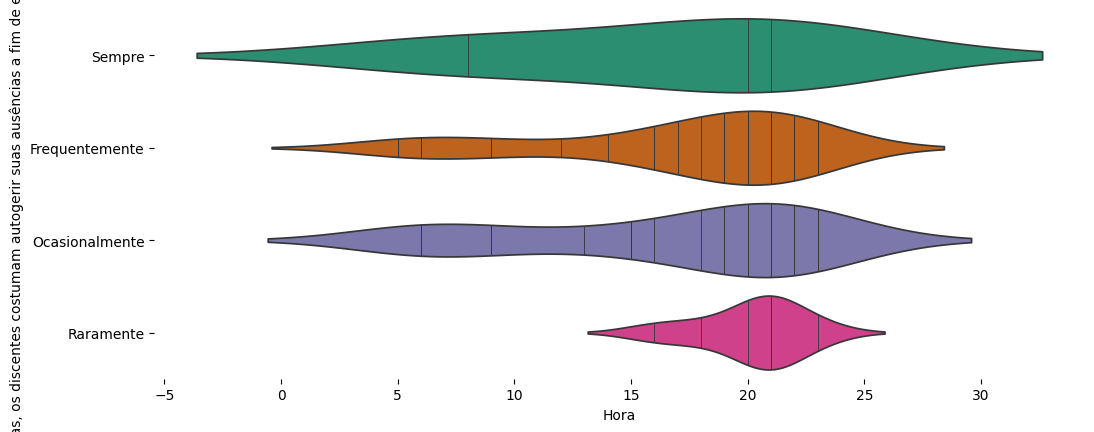

In [ ]:
# @title Distribuição horária da autogestão dos discentes em relação às faltas


figsize = (12, 1.2 * len(df['Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Hora', y='Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-502-838597853.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Hora', y='Turno', inner='stick', palette='Dark2')


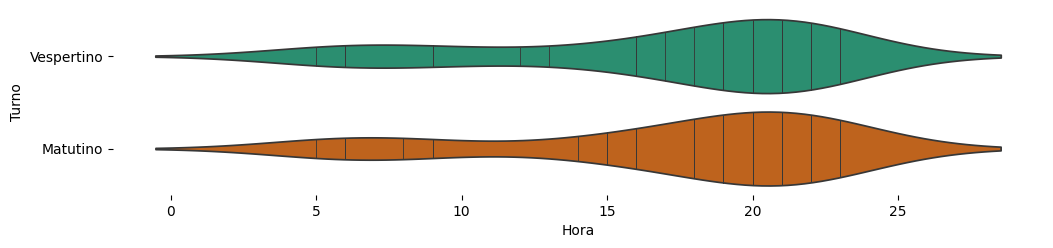

In [ ]:
# @title Distribuição horária das respostas por turno dos participantes

figsize = (12, 1.2 * len(df['Turno'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Hora', y='Turno', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-503-1737374884.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Hora', y='Semestre', inner='stick', palette='Dark2')


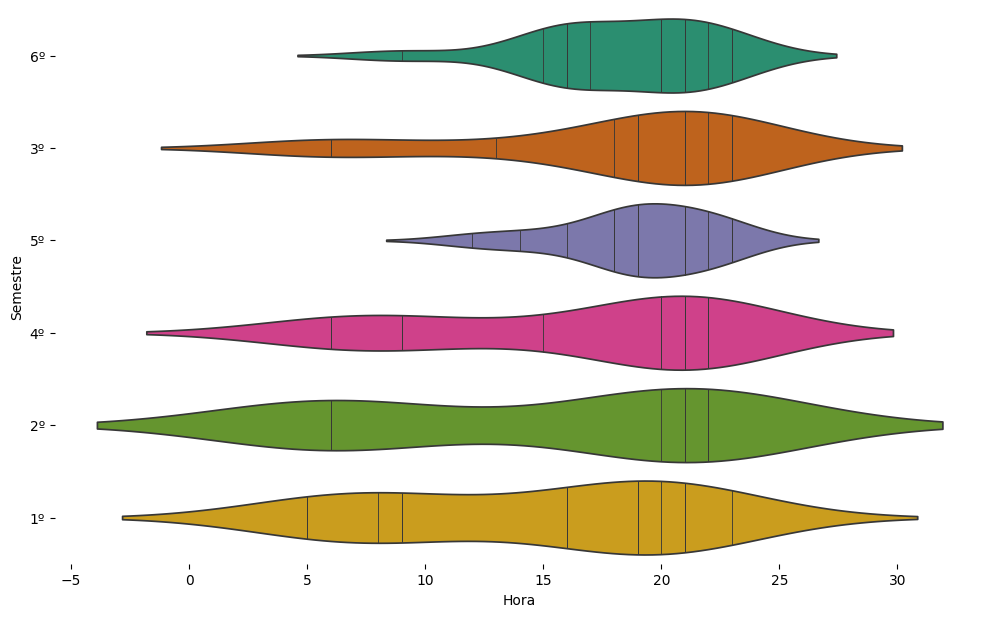

In [ ]:
# @title Distribuição horária das respostas por semestre dos alunos


figsize = (12, 1.2 * len(df['Semestre'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Hora', y='Semestre', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

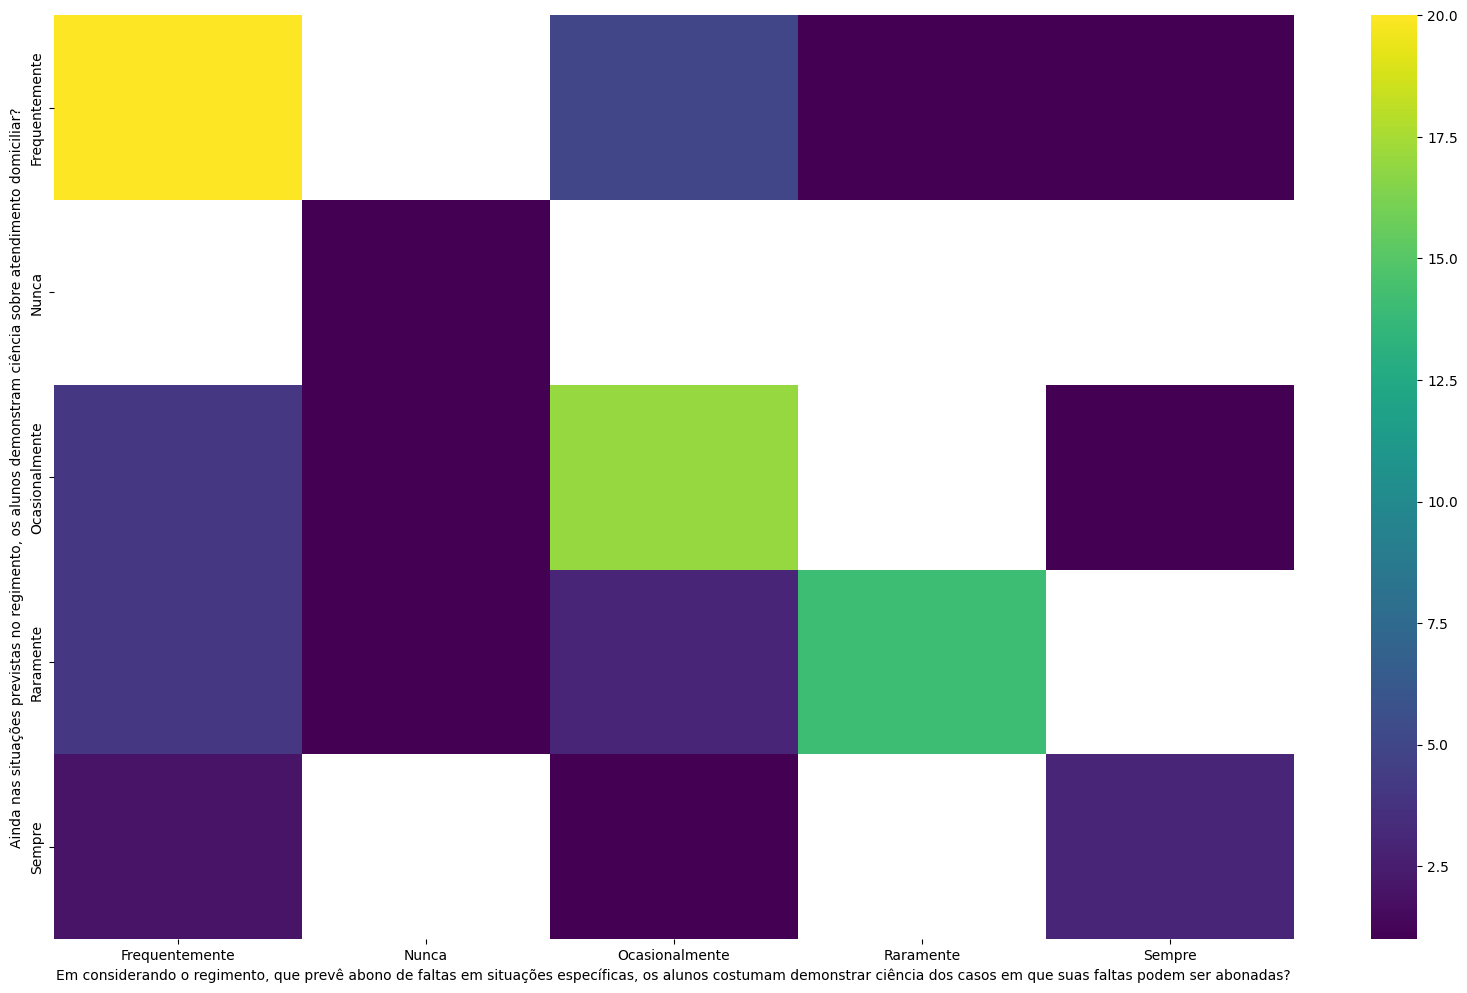

In [ ]:
# @title Cruzamento das percepções sobre abono de faltas e atendimento domiciliar conforme o regimento

plt.subplots(figsize=(20, 12))
df_2dhist = pd.DataFrame({
    x_label: grp['Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar?'].value_counts()
    for x_label, grp in df.groupby('Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?')
_ = plt.ylabel('Ainda nas situações previstas no regimento, os alunos demonstram ciência sobre atendimento domiciliar?')

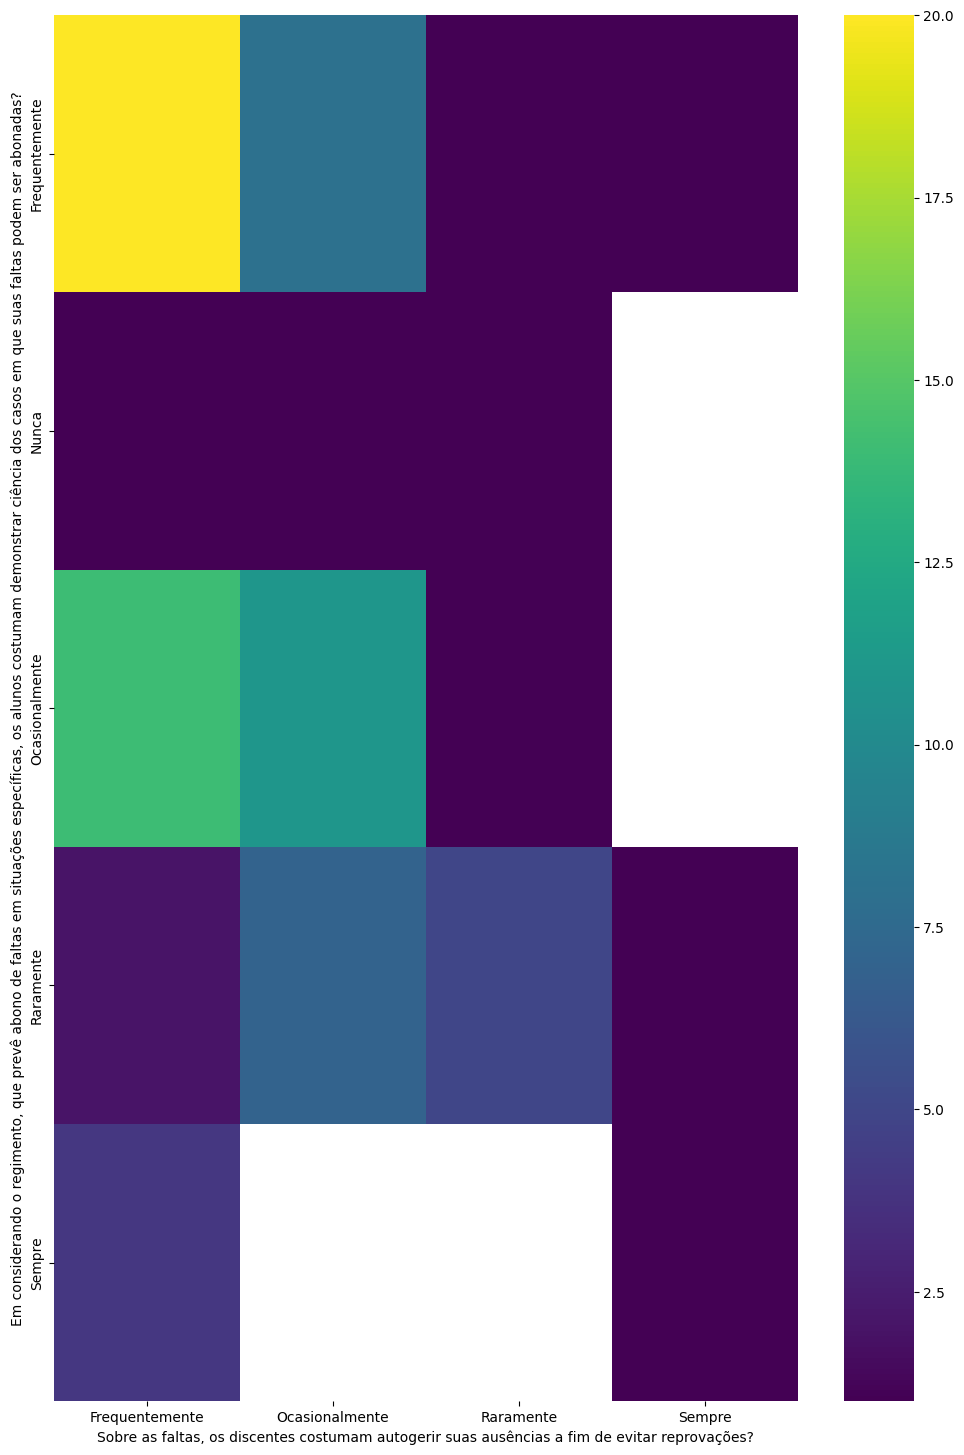

In [ ]:
# @title Cruzamento entre autogestão das ausências e conhecimento sobre abono de faltas segundo o regimento

plt.subplots(figsize=(12, 18))
df_2dhist = pd.DataFrame({
    x_label: grp['Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?'].value_counts()
    for x_label, grp in df.groupby('Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?')
_ = plt.ylabel('Em considerando o regimento, que prevê abono de faltas em situações específicas, os alunos costumam demonstrar ciência dos casos em que suas faltas podem ser abonadas?')

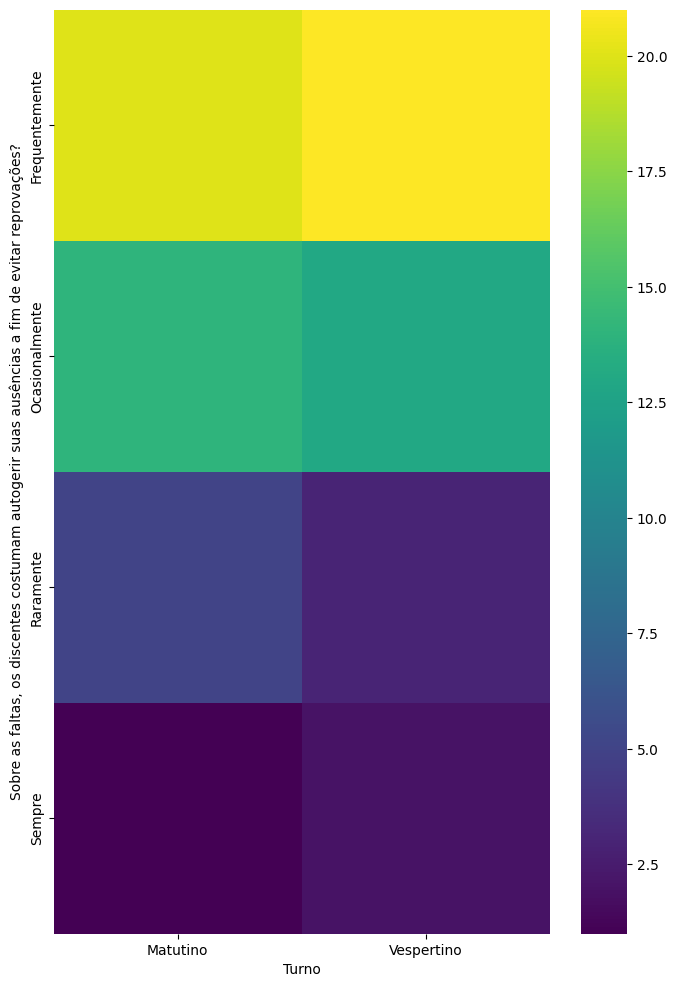

In [ ]:
# @title Relação entre turno e autogestão das faltas pelos discentes

plt.subplots(figsize=(8, 12))
df_2dhist = pd.DataFrame({
    x_label: grp['Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?'].value_counts()
    for x_label, grp in df.groupby('Turno')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Turno')
_ = plt.ylabel('Sobre as faltas, os discentes costumam autogerir suas ausências a fim de evitar reprovações?')

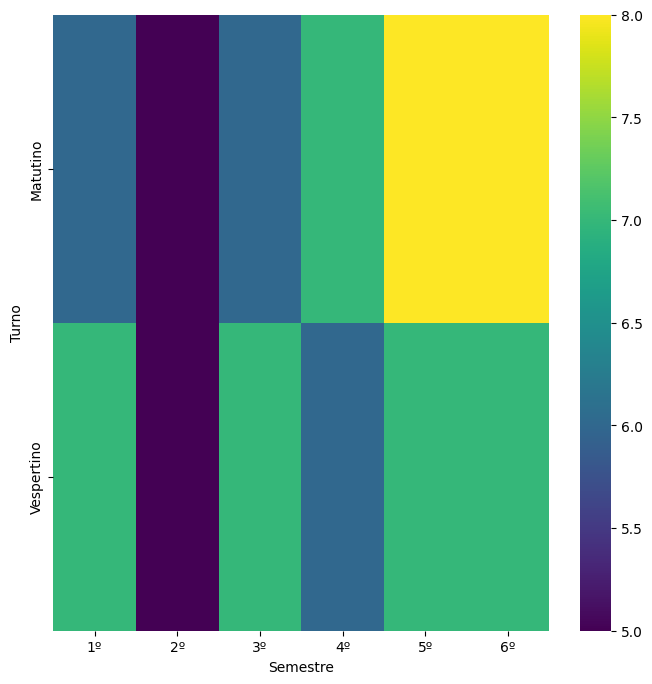

In [ ]:
# @title Distribuição dos alunos por turno em cada semestre

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Turno'].value_counts()
    for x_label, grp in df.groupby('Semestre')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Semestre')
_ = plt.ylabel('Turno')

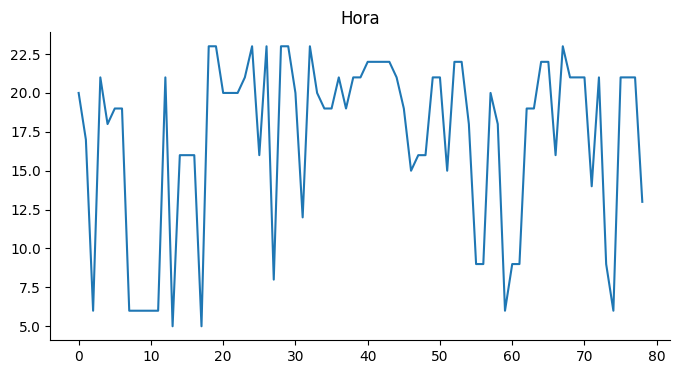

In [ ]:
# @title Evolução dos registros de horário (Hora) ao longo das observações

df['Hora'].plot(kind='line', figsize=(8, 4), title='Hora')
plt.gca().spines[['top', 'right']].set_visible(False)

#FIM